# Modeling TF-IDF + MLP (Multi Layer Perceptron) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

We rely on Galke et al. 2022 for the specific WideMLP Setup

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold,
    plot_skorch_history
)
from src.widemlp_skorch import ToFloat32Dense,make_widemlp_skorch # our skorch widemlp setup
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Repro Setup --- we try to make everything reproducible
import os, random, numpy as np, torch
SEED = 42  #global seed

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision('high')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


In [3]:
import torch #we want to use the gpu

print("Torch-Version:", torch.__version__)
print("CUDA-Toolchain in Torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU-Name:", torch.cuda.get_device_name(0))

#test
x = torch.randn(5000, 5000, device="cuda")
y = torch.matmul(x, x)
print("Device:", y.device)


Torch-Version: 2.5.1
CUDA-Toolchain in Torch: 12.4
CUDA available: True
GPU-Name: NVIDIA GeForce RTX 4050 Laptop GPU
Device: cuda:0


**a) MLPClassifier with basic preprocessed data**

In [4]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MLP TPE basic

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__lr': 0.009556553896706736, 'clf__batch_size': 16, 'clf__module__hidden_dim': 128, 'clf__module__dropout_p': 0.6256742348460601, 'clf__optimizer__weight_decay': 0.0002634668868146229, 'mlp_pos_weight': 4.719014203548225, 'clf__criterion__label_smoothing': 0.08956559224365078, 'select__k': 236}
Best F2 score during optimization: 0.832

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


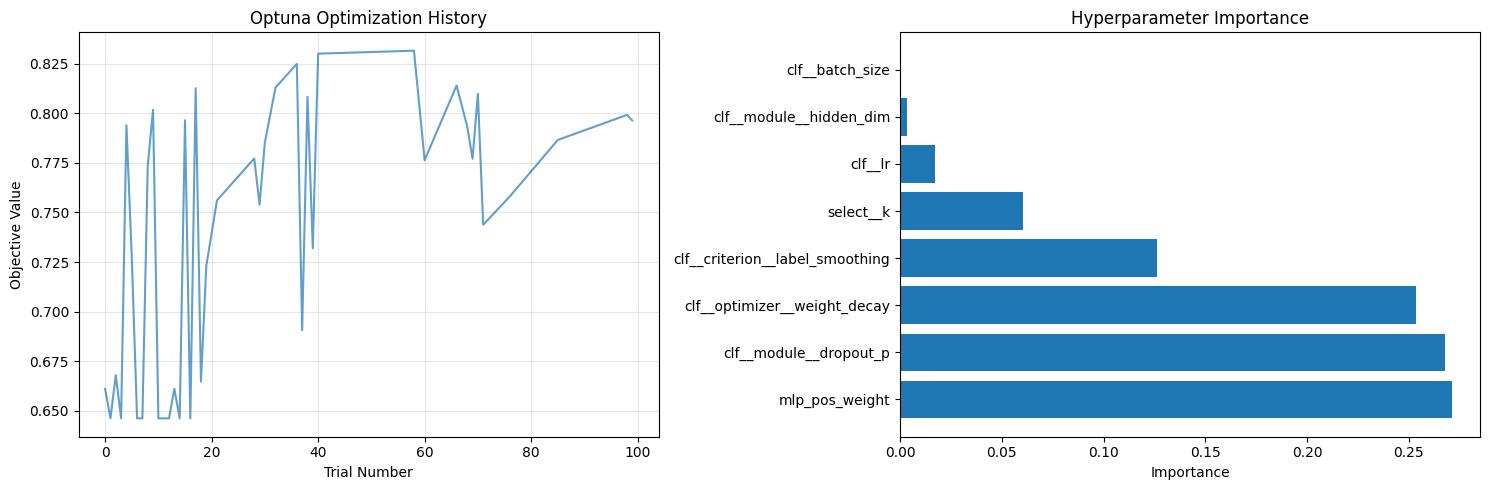


2. Parameter Value Distributions:


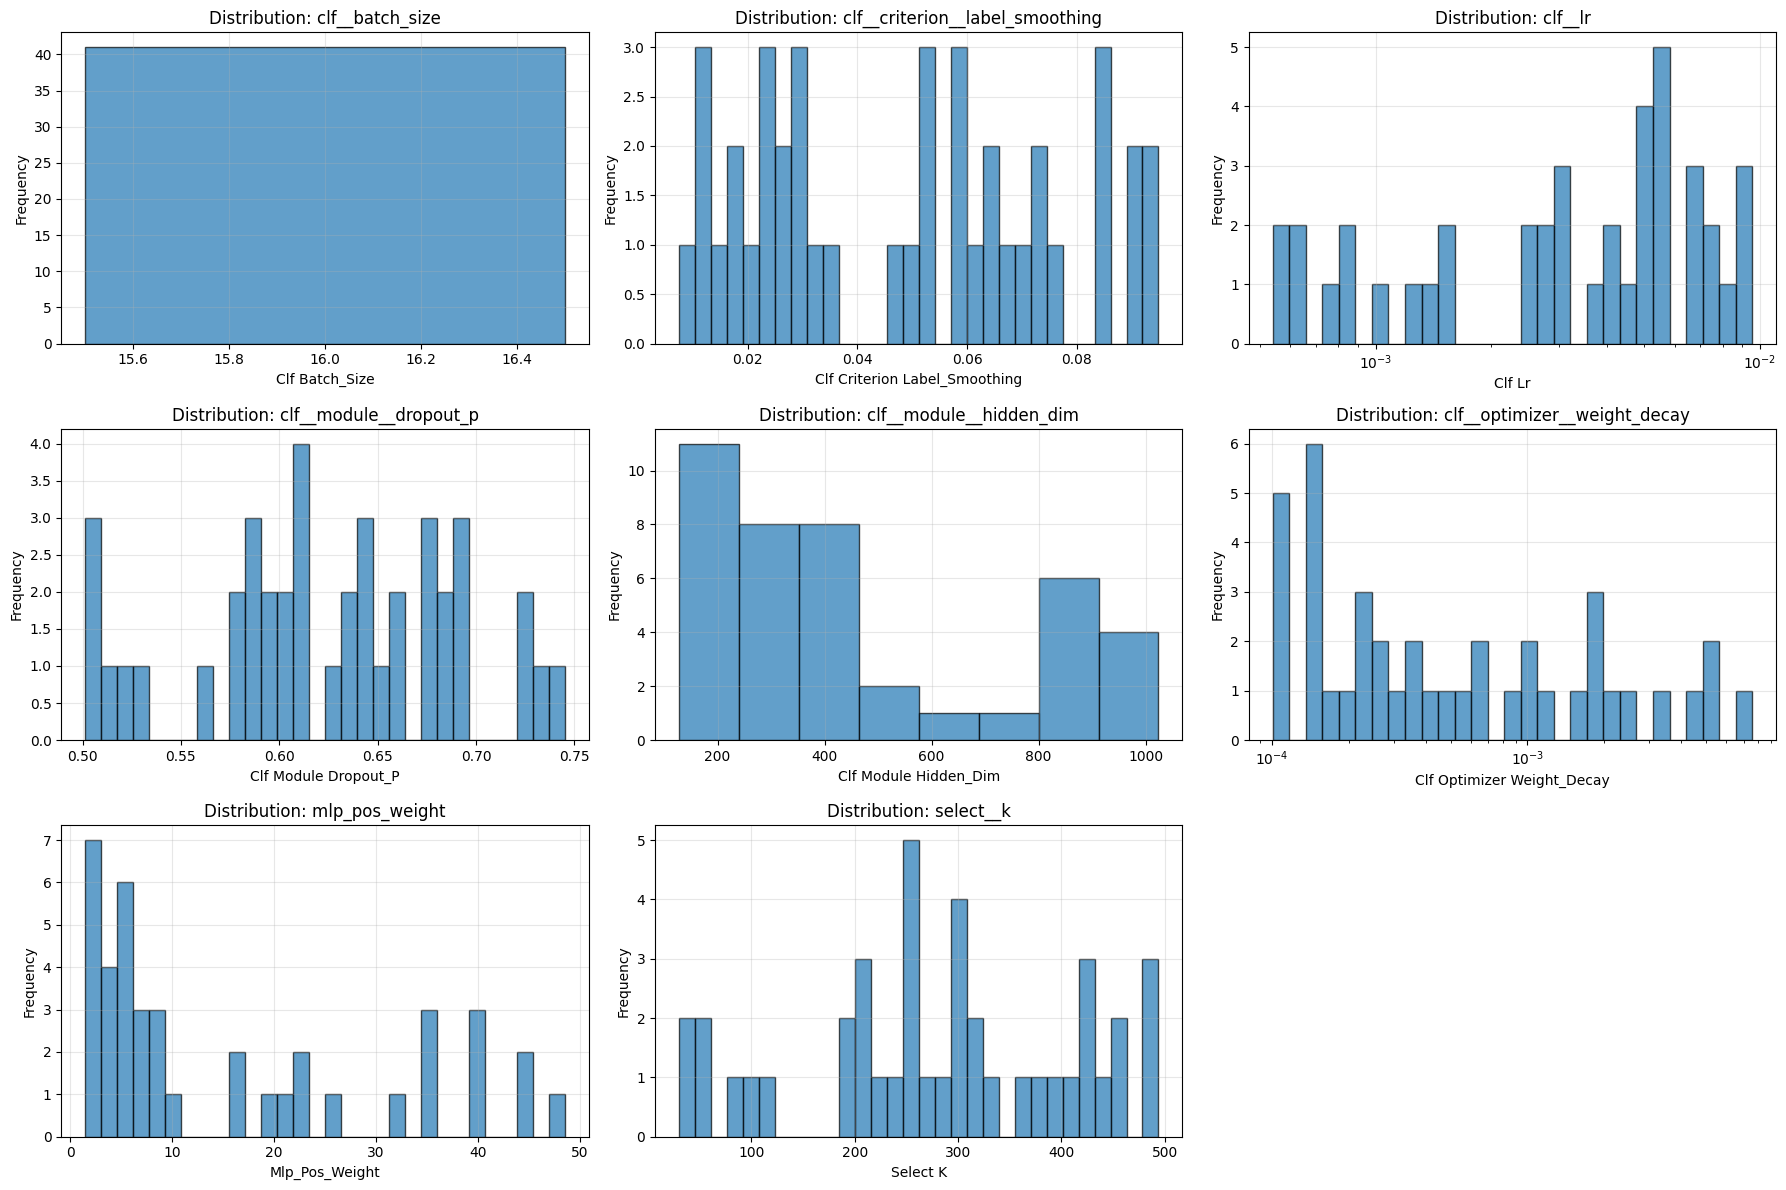


3. Performance vs Individual Parameters:


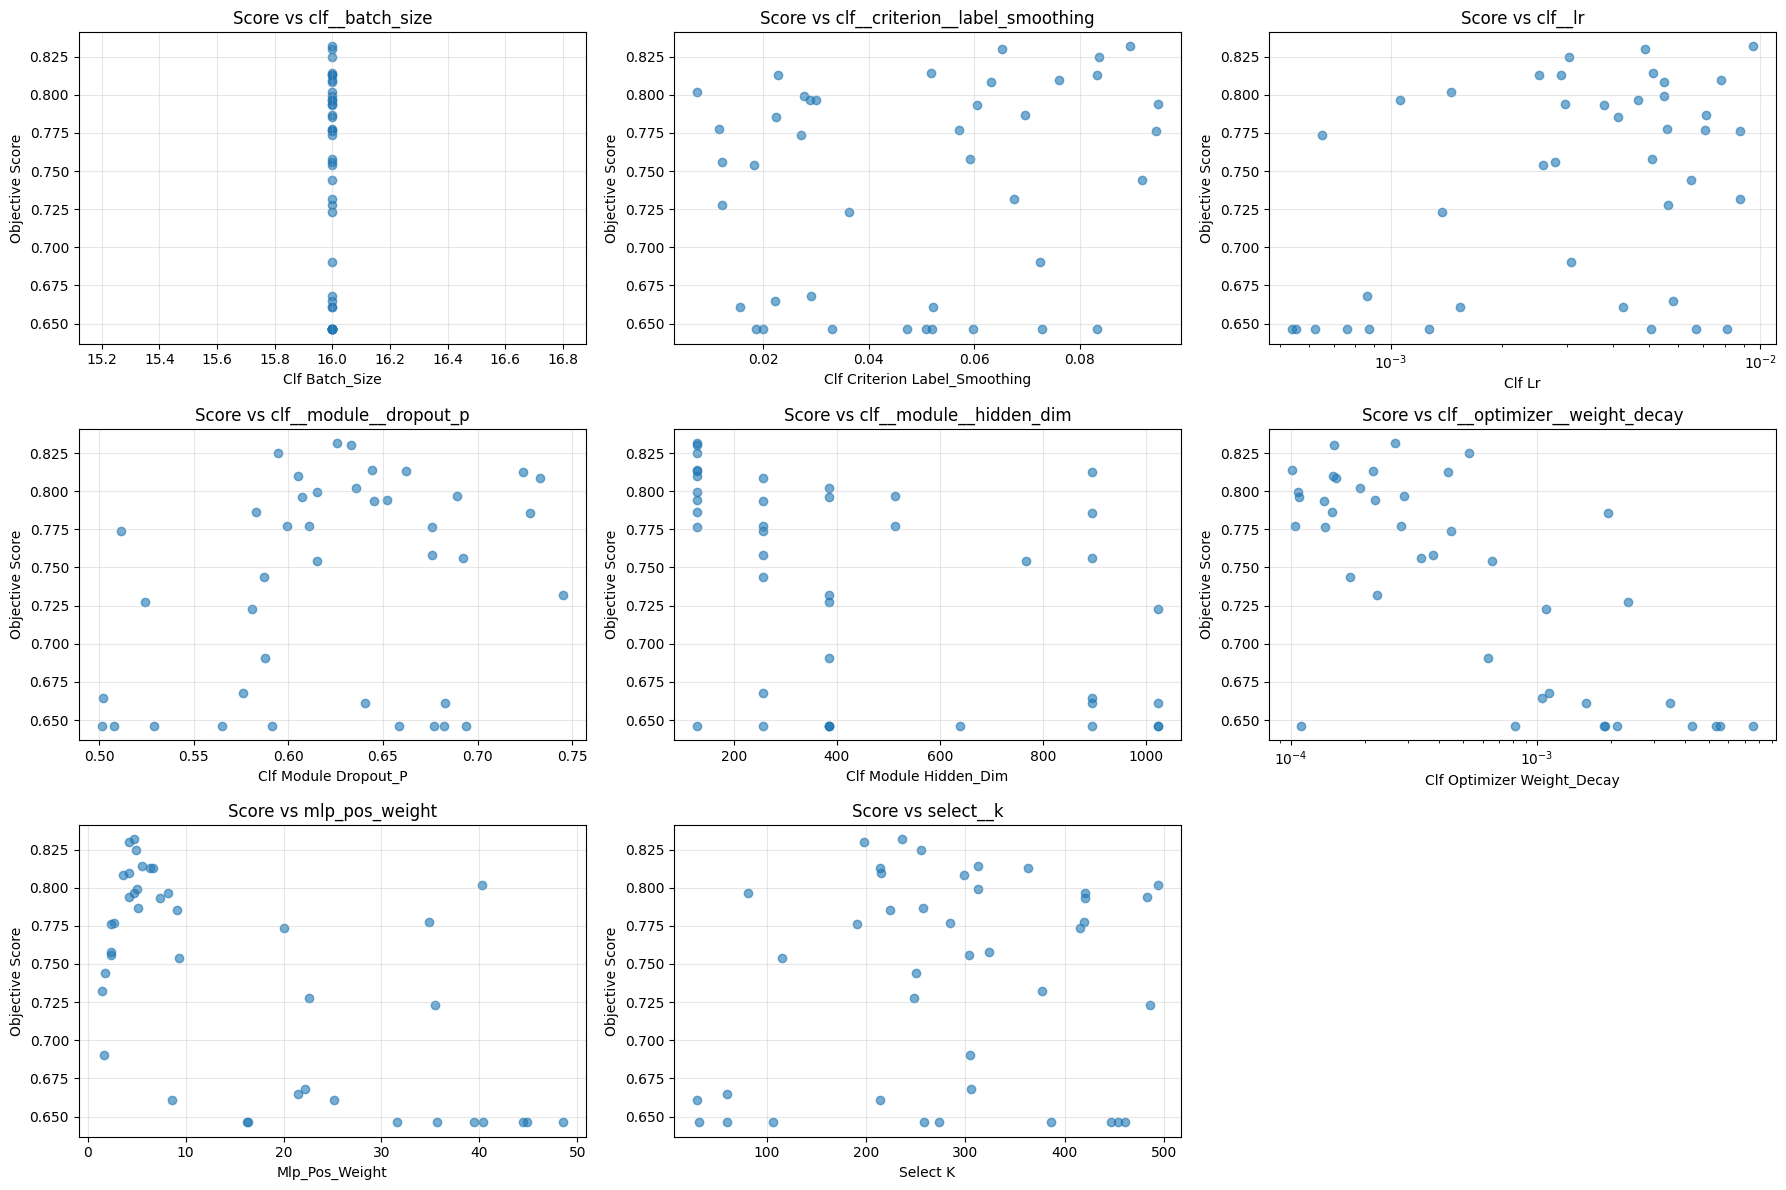


4. Convergence Analysis:


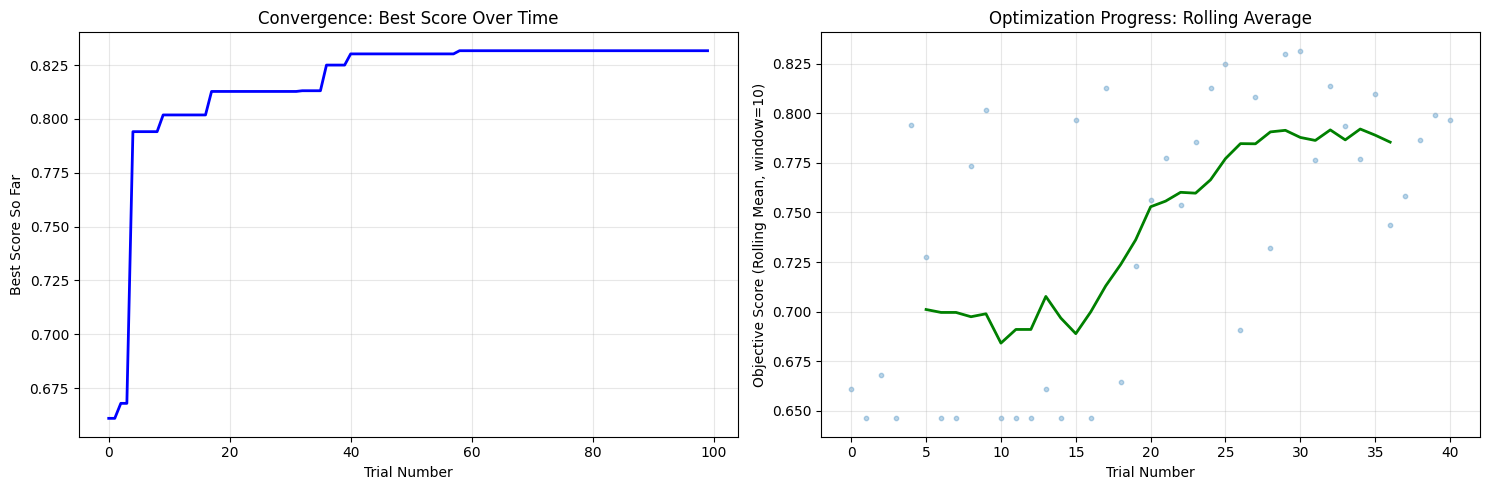


5. Trial Status Overview:


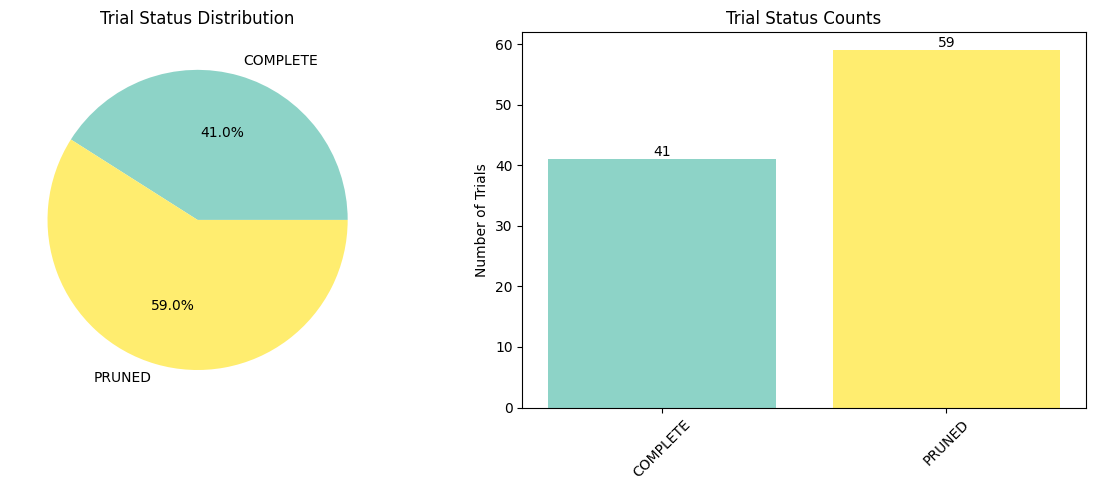


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight k           
------------------------------------------------------------------------------------------------------------------------------------
1    58      0.8316     16           0.0896       0.0096       0.6257       128          0.0003       4.7190       236         
2    40      0.8302     16           0.0654       0.0049       0.6331       128          0.0001       4.2297       198         
3    36      0.8250     16           0.0837       0.0030       0.5947       128          0.0005       4.9685       255         
4    66      0.8141     16           0.0519       0.0051       0.6443       128          0.0001       5.5046       313         
5    32      0.8131     16           0.0834       0.0029       0.6623       128          0.0002       6.7089       363         
6    17      0.8127     16           0.0228       0.0025       0.7240 

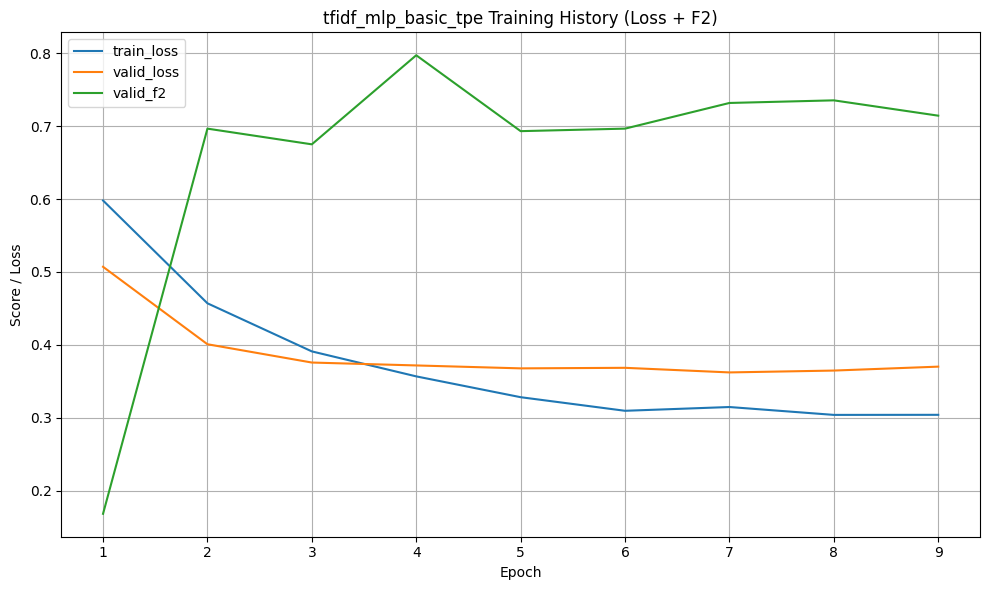


Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.143
CV F2-score with optimized threshold: 0.837

Generating unbiased threshold visualization...


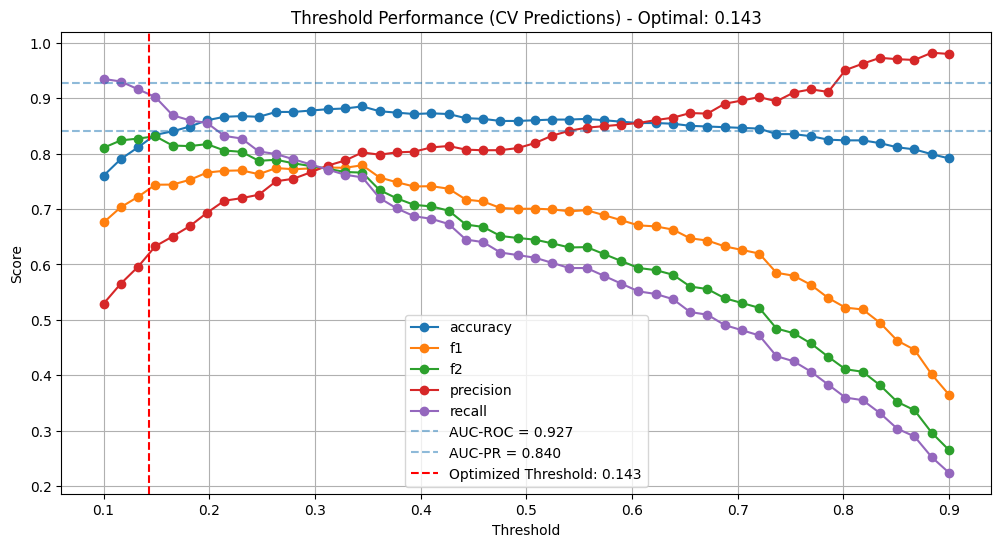

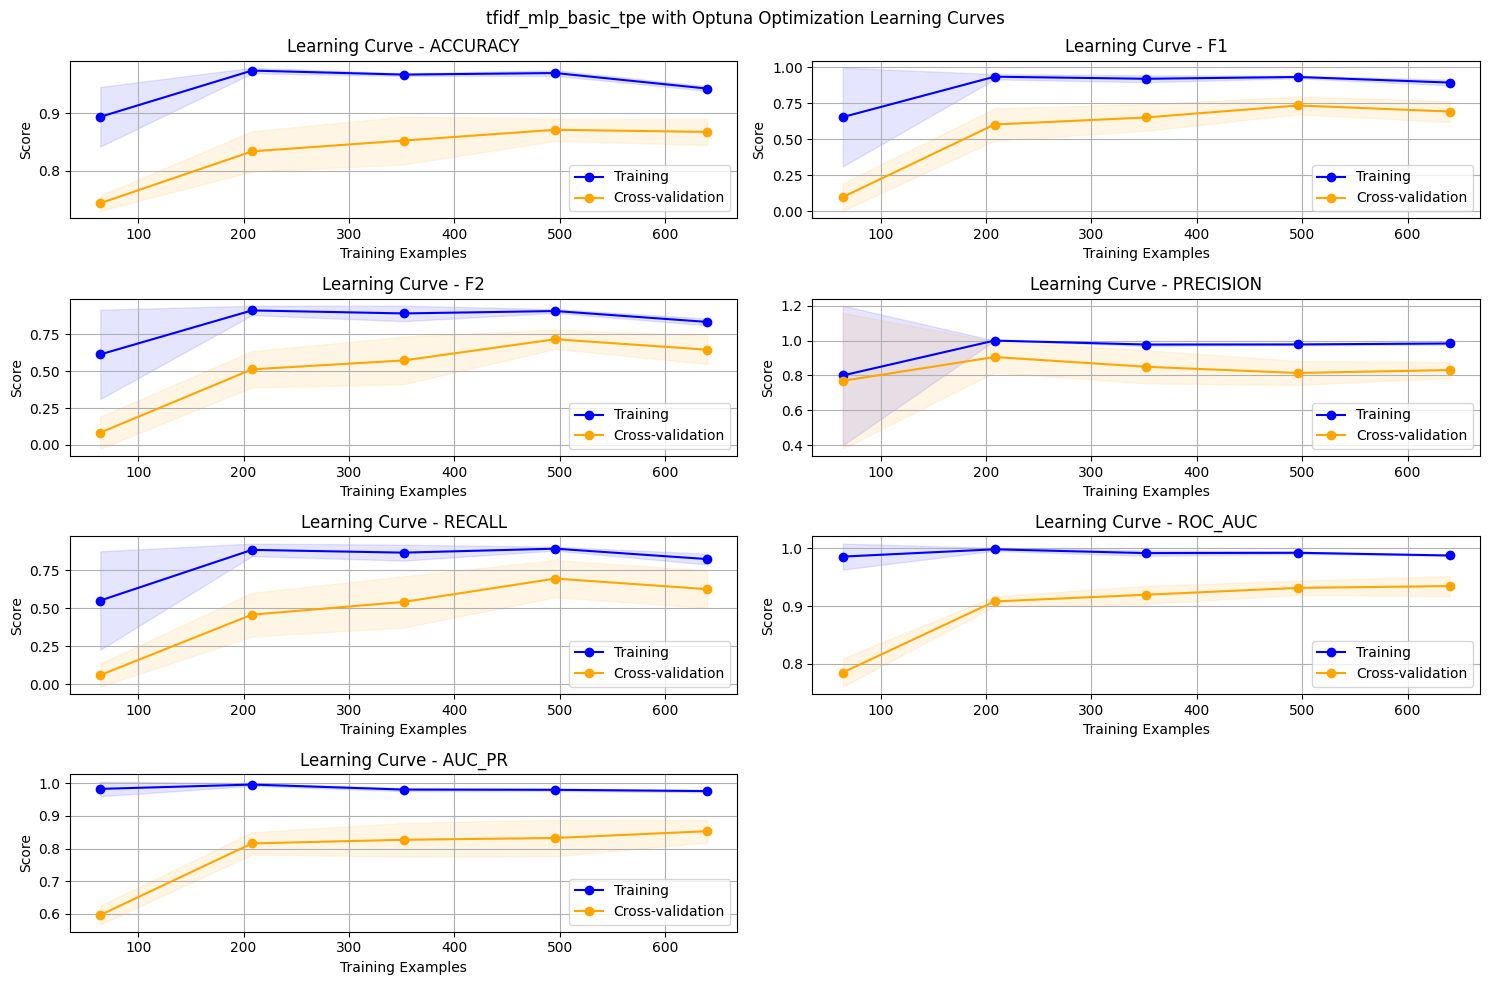


Final Threshold: 0.14
F2-score with default threshold (0.5): 0.673

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       146
           1       0.52      0.91      0.66        54

    accuracy                           0.75       200
   macro avg       0.74      0.80      0.73       200
weighted avg       0.84      0.75      0.76       200

Additional Metrics:
Accuracy   0.750
F2-score   0.790
AUC-ROC    0.910
AUC-PR     0.810



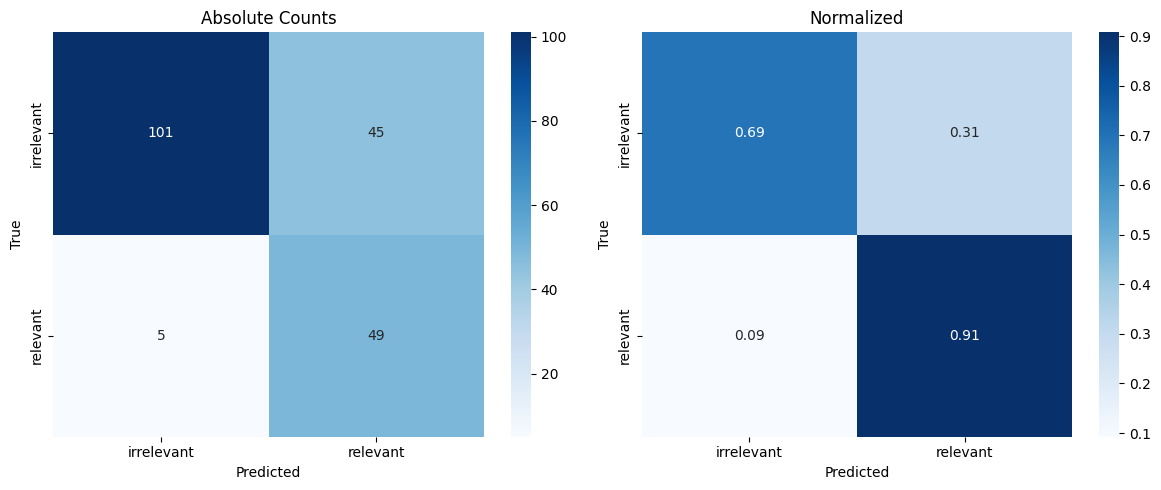

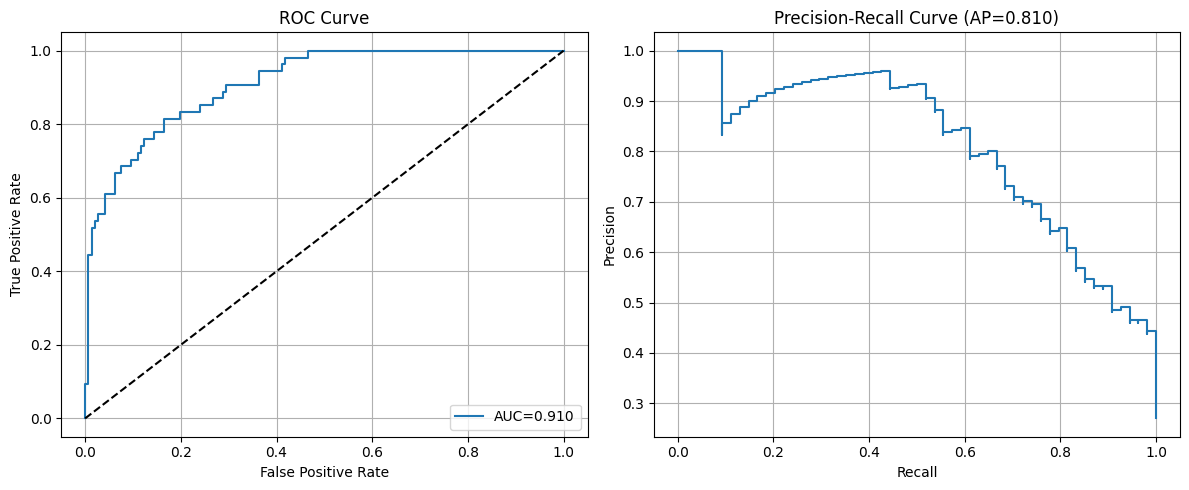


Model saved as model_tfidf_mlp_basic_tpe.joblib


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, #we use early stopping
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True,  # use GPU
                use_early_stopping=True,
                )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 5e-4, 1e-2, log=True),  # Adam LR around 1e-3 
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [16]),  # small batches per paper;
    "clf__module__hidden_dim": lambda t: t.suggest_int("clf__module__hidden_dim", 128, 1024, step=128),  # structured width search around 1024
    "clf__module__dropout_p": lambda t: t.suggest_float("clf__module__dropout_p", 0.5, 0.75),  # focus around 0.5 as optimum per paper
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 1e-4, 1e-2, log=True),  # tiny L2 for stability
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("mlp_pos_weight", 1.0, 50.0)], dtype=torch.float32),  # class weight for positives, force GPU
    "clf__criterion__label_smoothing": lambda t: t.suggest_float("clf__criterion__label_smoothing", 0.0, 0.1), #add some regularization due to overfitting risk
    "select__k": lambda t: t.suggest_int("select__k", 1, 500),  # chi² filter
}



model_name = "tfidf_mlp_basic_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_mlp,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "mlp",
    n_trials=100,  # Intelligent search with early stopping
    n_startup_trials=20, # less aggressive prunning
    n_warmup_steps=5,  # first 5 epochs not pruned
    intervall_steps=1, # prunning possible for every epoch
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



MLP GridSearch basic

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__module__hidden_dim': 96, 'clf__module__dropout_p': 0.63, 'clf__optimizer__weight_decay': 0.0001, 'mlp_pos_weight': 6.0, 'clf__lr': 0.0049, 'clf__criterion__label_smoothing': 0.065, 'select__k': 236, 'clf__batch_size': 16}
Best F2 score during optimization: 0.837

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


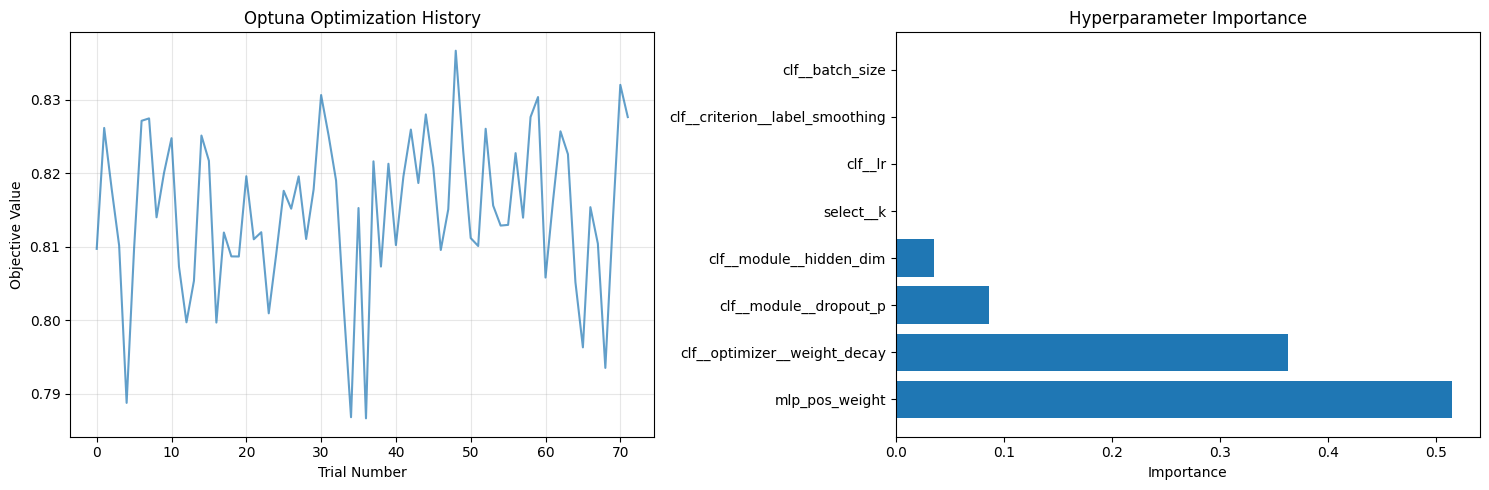


2. Parameter Value Distributions:


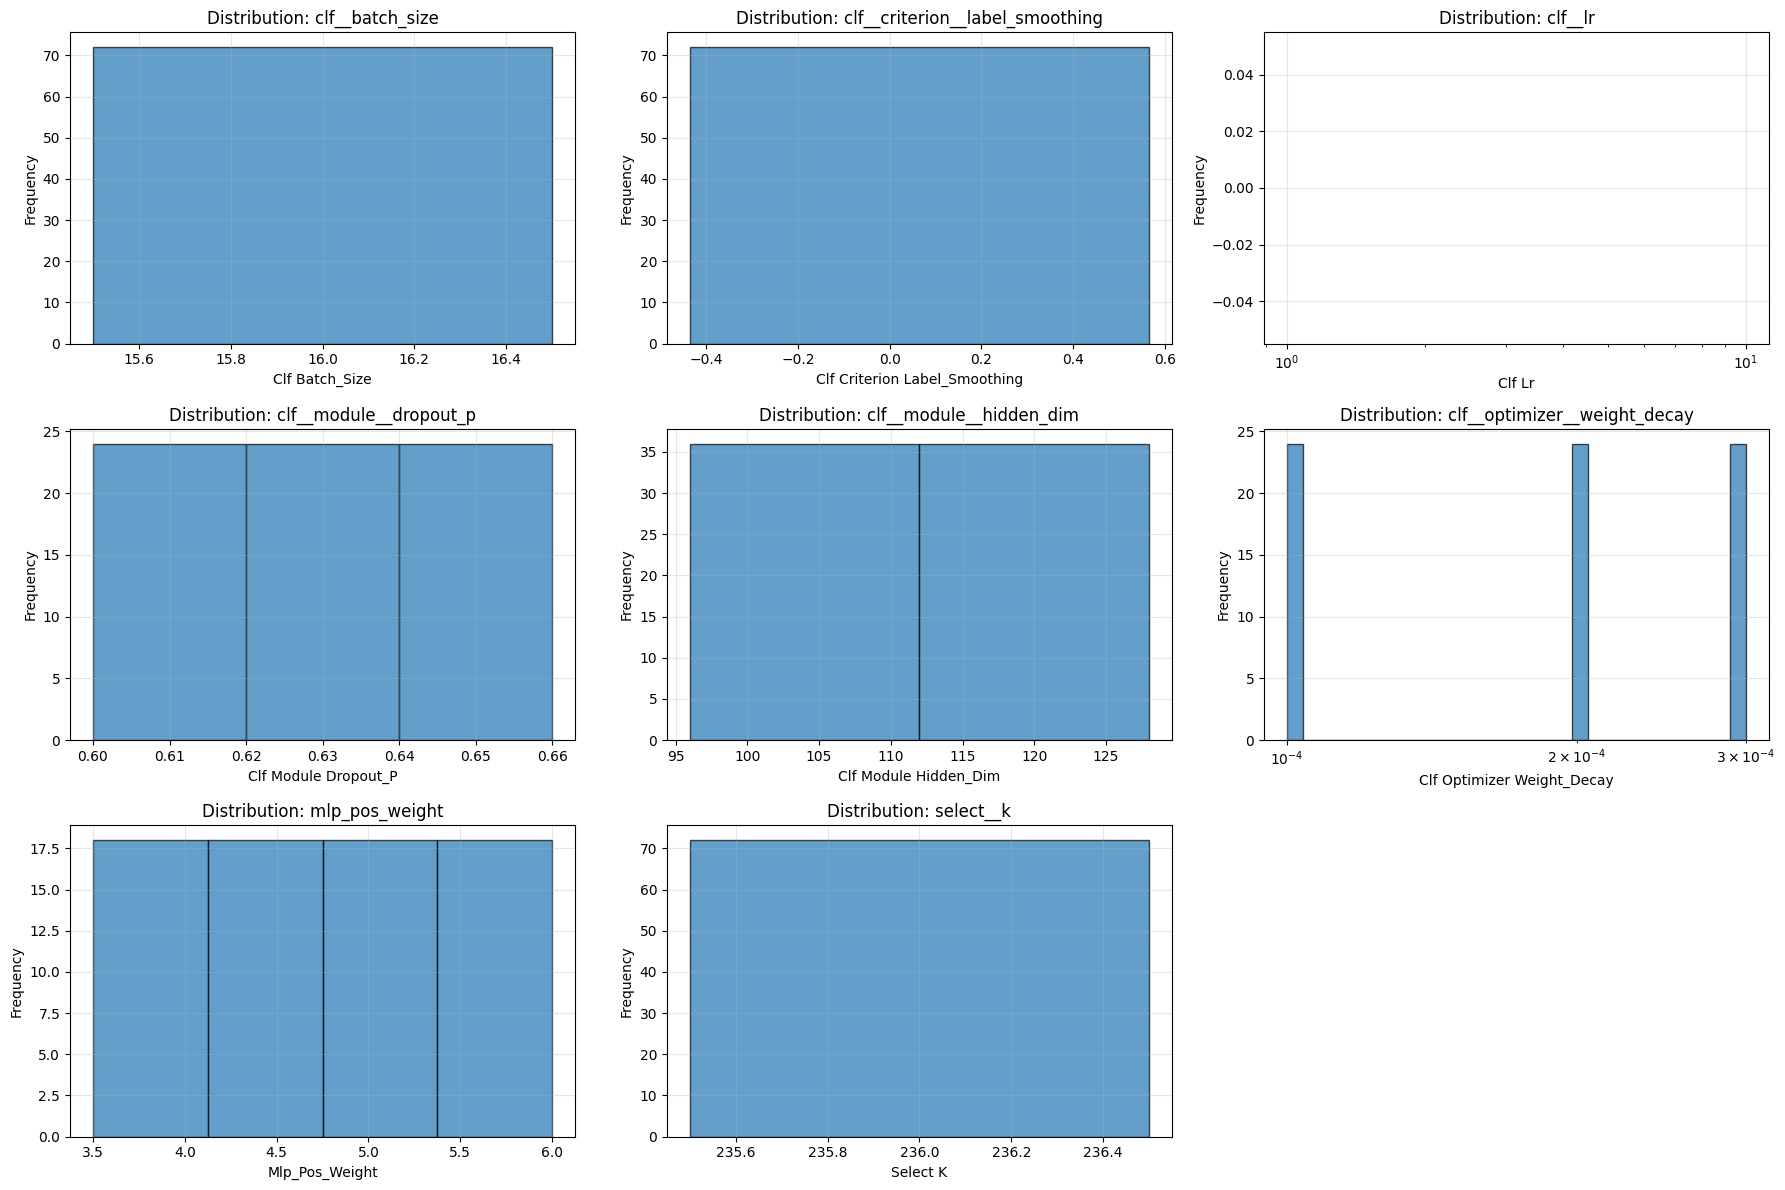


3. Performance vs Individual Parameters:


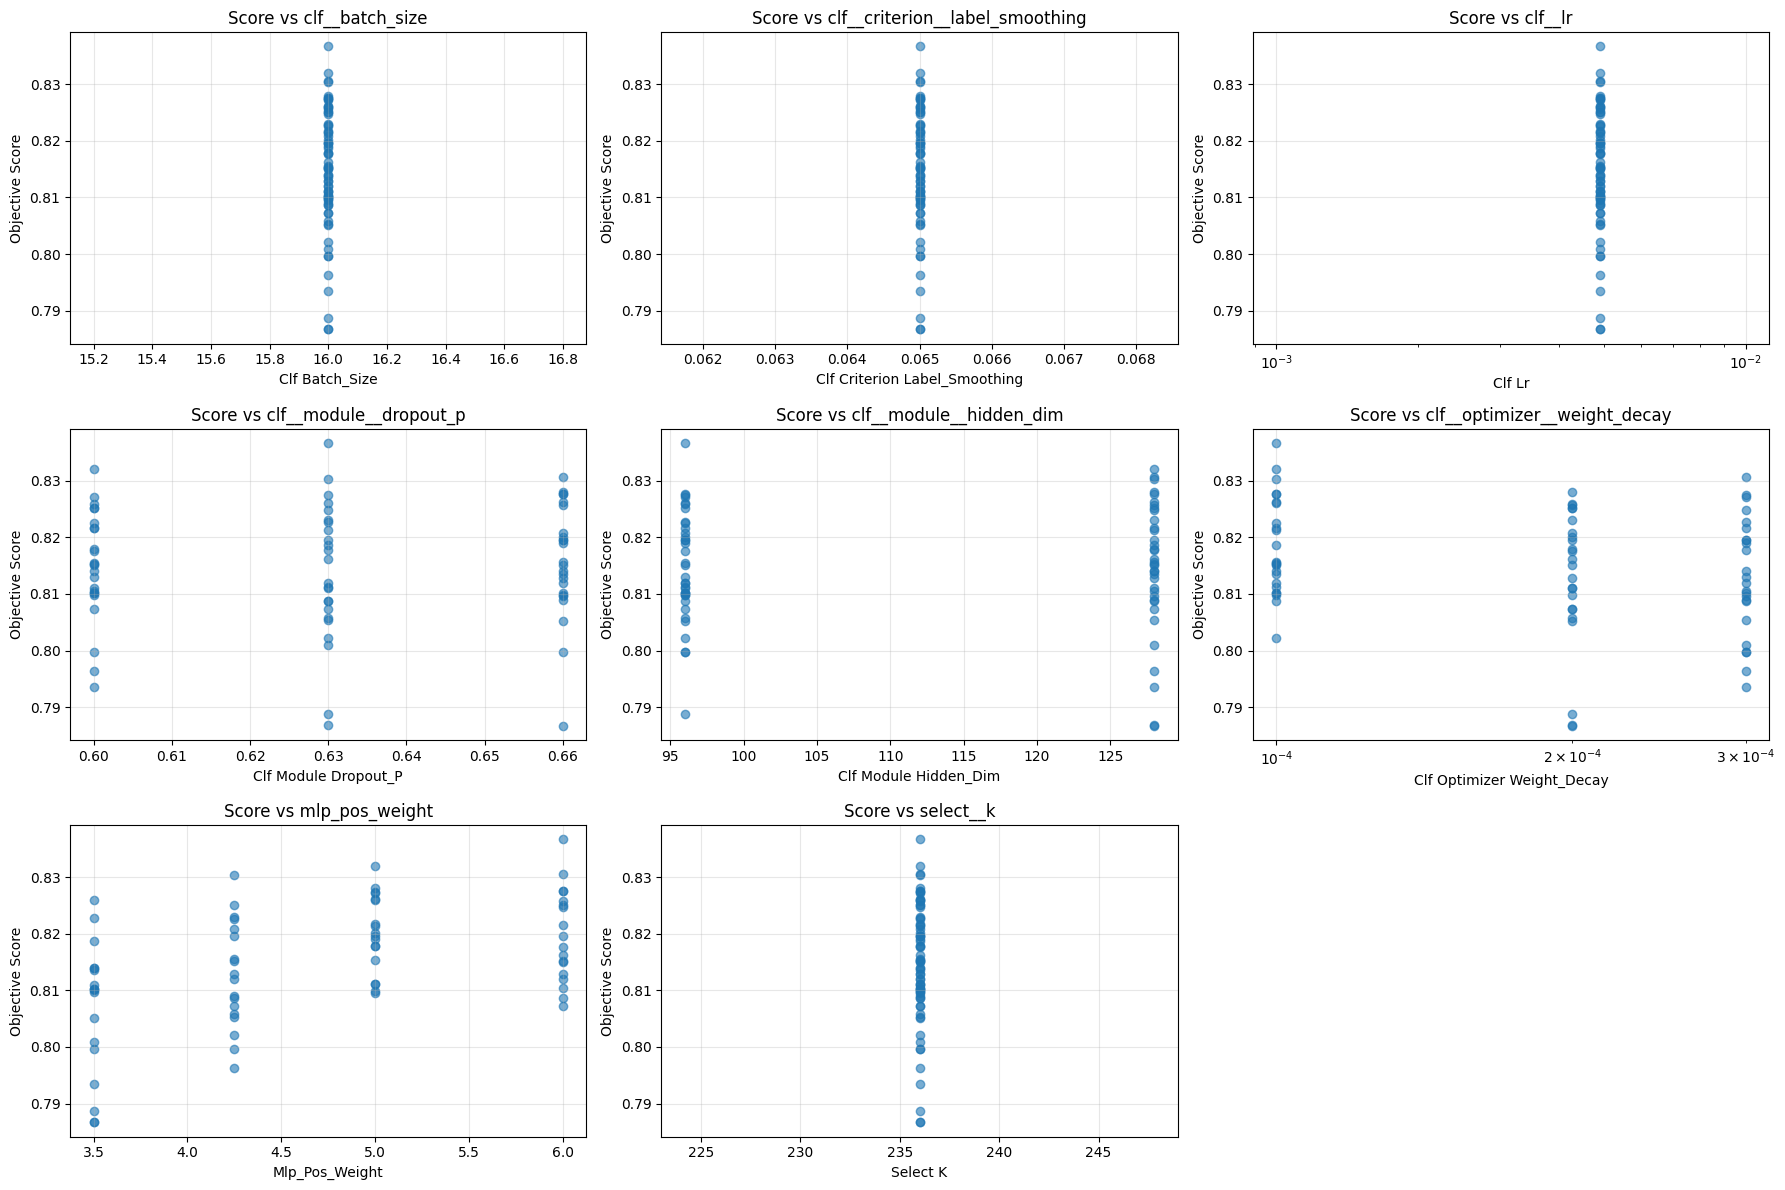


4. Convergence Analysis:


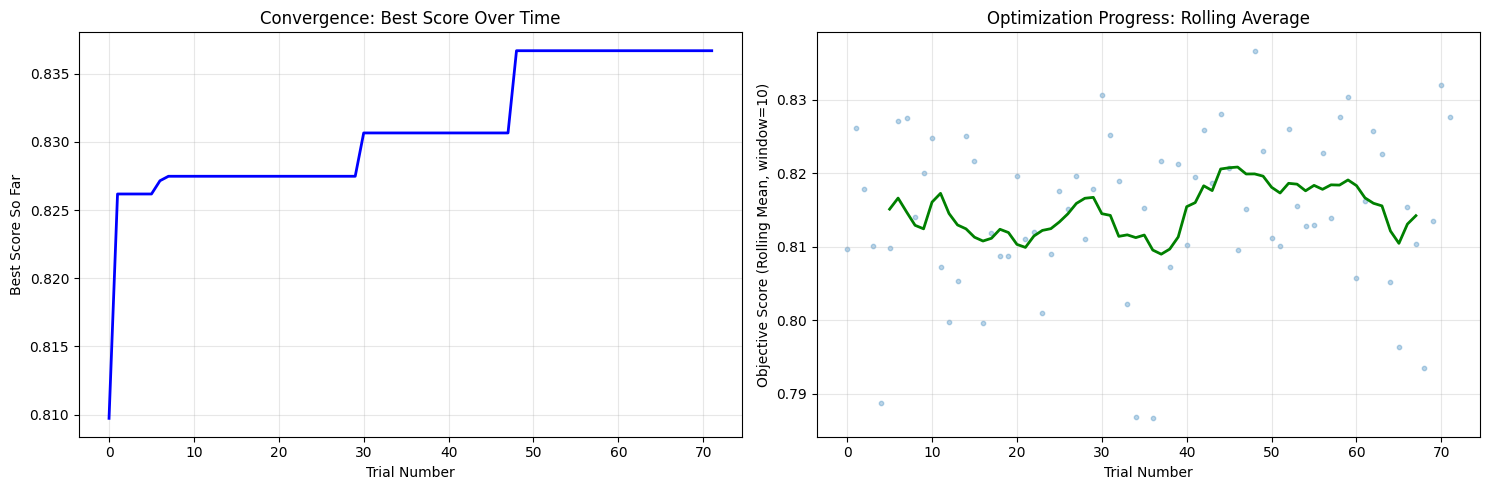


5. Trial Status Overview:


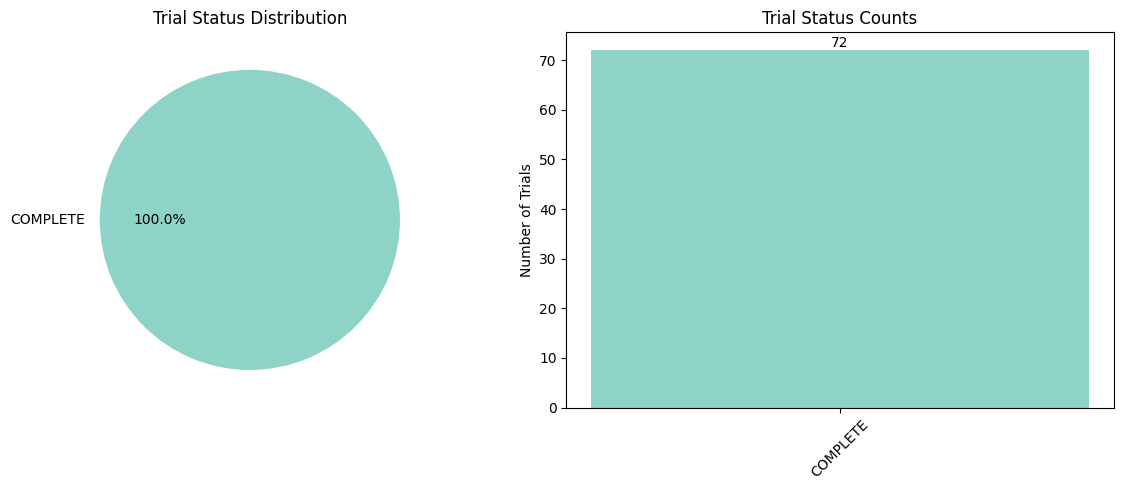


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight k           
------------------------------------------------------------------------------------------------------------------------------------
1    48      0.8367     16           0.0650       0.0049       0.6300       96           0.0001       6.0000       236         
2    70      0.8320     16           0.0650       0.0049       0.6000       128          0.0001       5.0000       236         
3    30      0.8307     16           0.0650       0.0049       0.6600       128          0.0003       6.0000       236         
4    59      0.8304     16           0.0650       0.0049       0.6300       128          0.0001       4.2500       236         
5    44      0.8280     16           0.0650       0.0049       0.6600       128          0.0002       5.0000       236         
6    58      0.8277     16           0.0650       0.0049       0.6600 

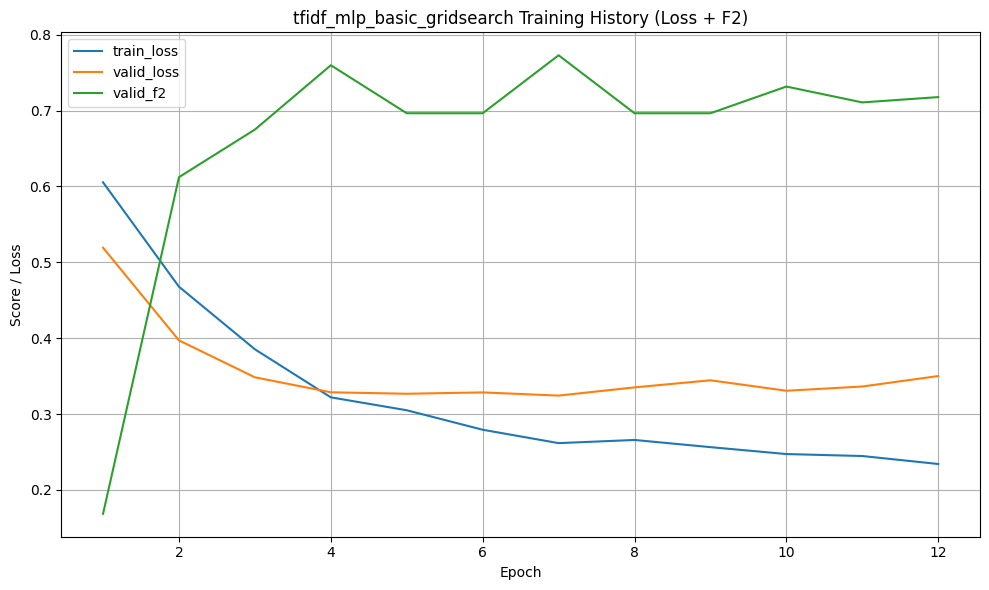


Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.138
CV F2-score with optimized threshold: 0.838

Generating unbiased threshold visualization...


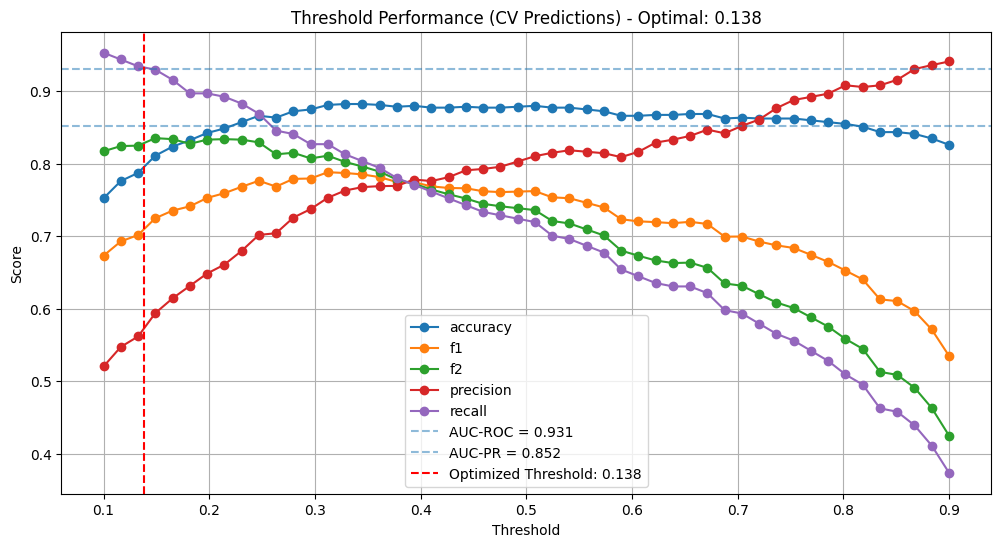

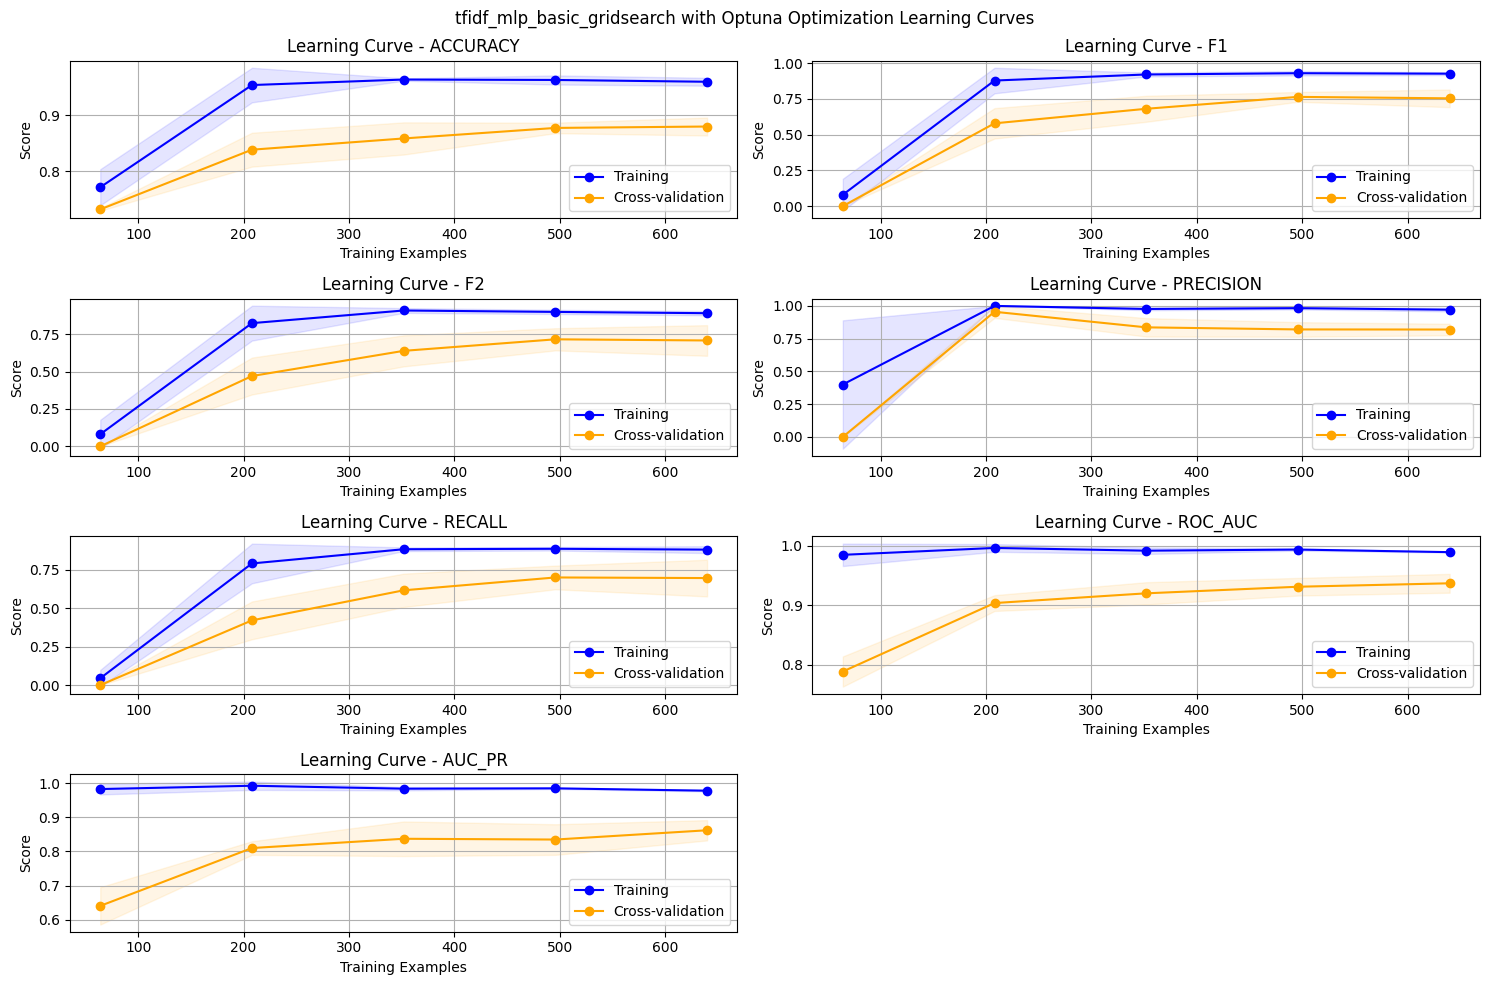


Final Threshold: 0.14
F2-score with default threshold (0.5): 0.630

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       146
           1       0.58      0.87      0.70        54

    accuracy                           0.80       200
   macro avg       0.76      0.82      0.77       200
weighted avg       0.84      0.80      0.81       200

Additional Metrics:
Accuracy   0.795
F2-score   0.791
AUC-ROC    0.925
AUC-PR     0.833



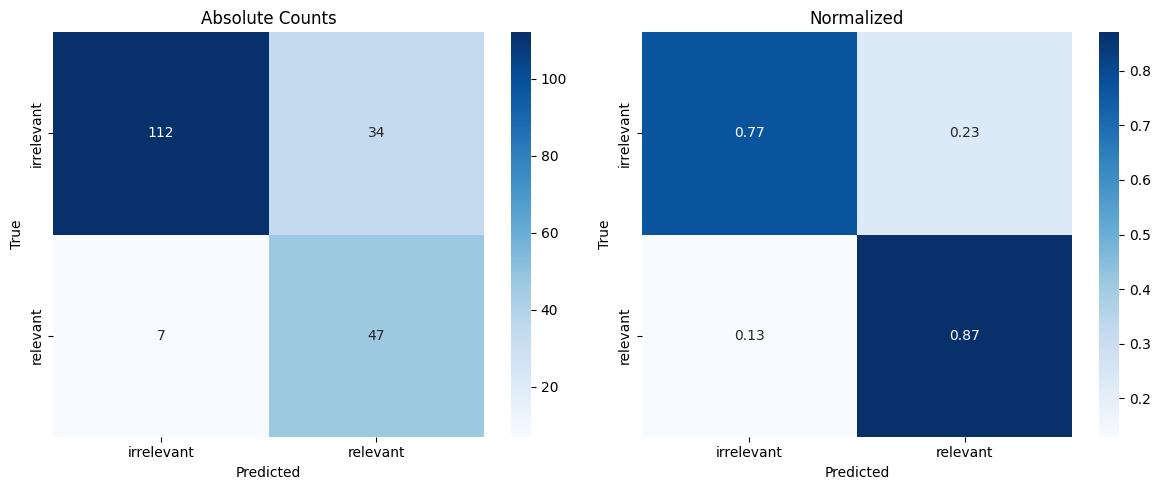

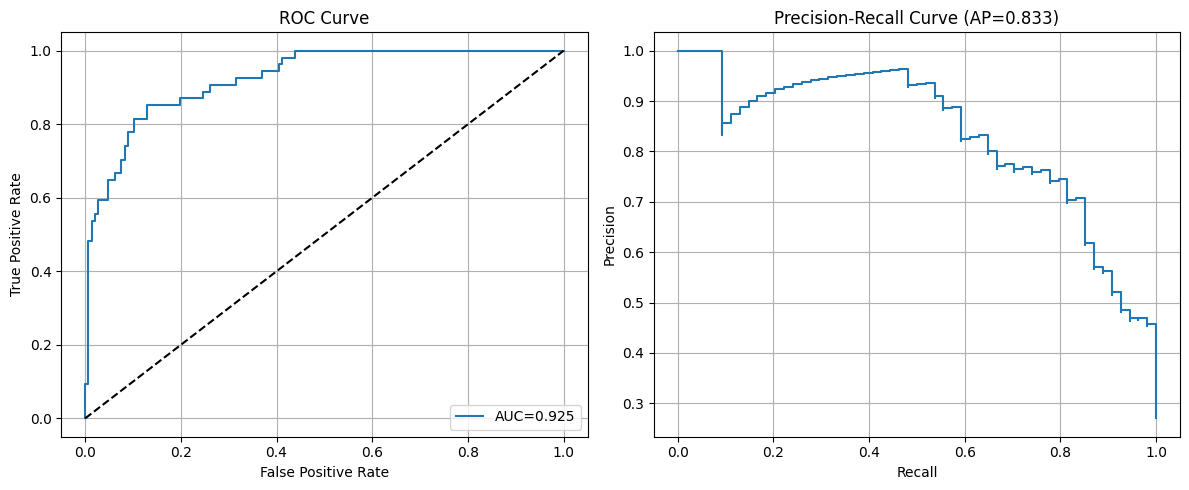


Model saved as model_tfidf_mlp_basic_gridsearch.joblib


In [9]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True,  # use GPU
                use_early_stopping=True, # employ early stopping, see for details in widemlp_skorch.py
                )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearch

param_grid = {
    "clf__module__hidden_dim": [96, 128],                 # top trials sat at 128 (min) → bias down; test even leaner capacity
    "clf__module__dropout_p":  [0.60, 0.63, 0.66],        # cluster around ~0.62–0.66 → narrow corridor around the sweet spot
    "clf__optimizer__weight_decay": [1e-4, 2e-4, 3e-4],   # best runs in ~1e-4–3e-4 → keep tiny L2; slight upper wiggle
    "mlp_pos_weight": [3.5, 4.25, 5.0, 6.0],              # strongest driver in importance → give this the most room (4 values)

    "clf__lr": [0.0049],                                  # fix at TPE optimum for efficiency (can sweep later if needed)
    "clf__criterion__label_smoothing": [0.065],           # fix at best; minor lever vs. the four above
    "select__k": [236],                                   # fix near best (236) to avoid exploding combos; sweep later if needed
    "clf__batch_size": [16],                               # fixed across all top trials; stable by design
}
model_name = "tfidf_mlp_basic_gridsearch"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_mlp,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")


**b) MLP based on advanced preprocessed data**

In [7]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MLP TPE advanced

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__lr': 0.004054763320034597, 'clf__batch_size': 16, 'clf__module__hidden_dim': 512, 'clf__module__dropout_p': 0.7325159584179735, 'clf__optimizer__weight_decay': 0.0005824698063536336, 'mlp_pos_weight': 7.181614549481585, 'clf__criterion__label_smoothing': 0.07402551502436842, 'select__k': 417, 'phrases__enable': True, 'phrases__min_count': 28, 'phrases__threshold': 88.14108265111986}
Best F2 score during optimization: 0.844

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


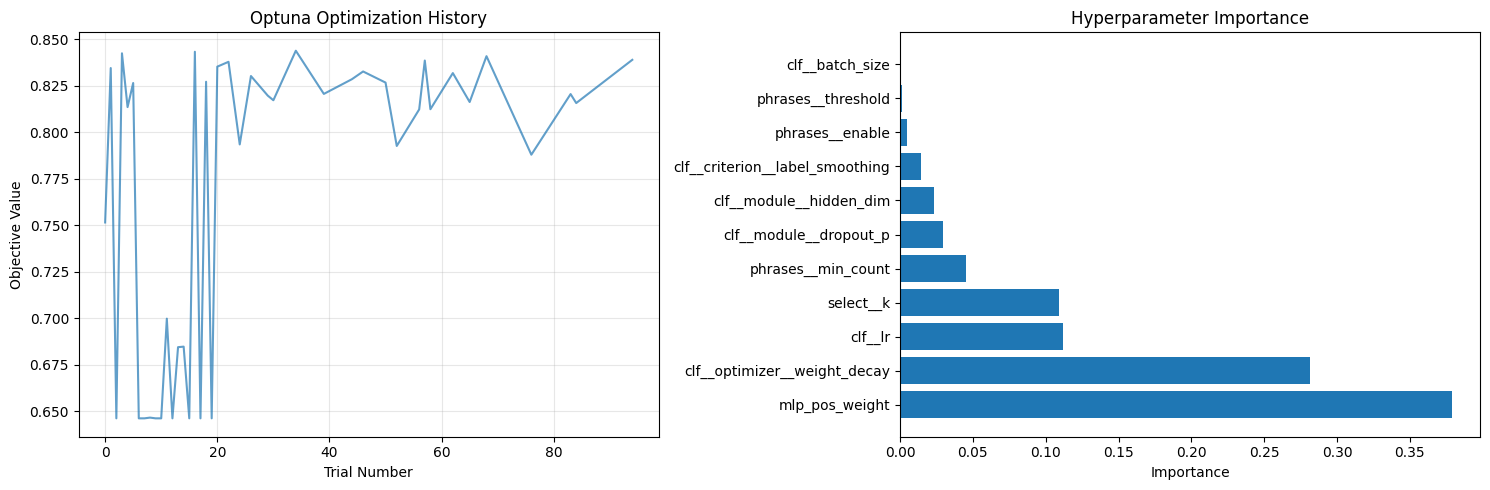


2. Parameter Value Distributions:


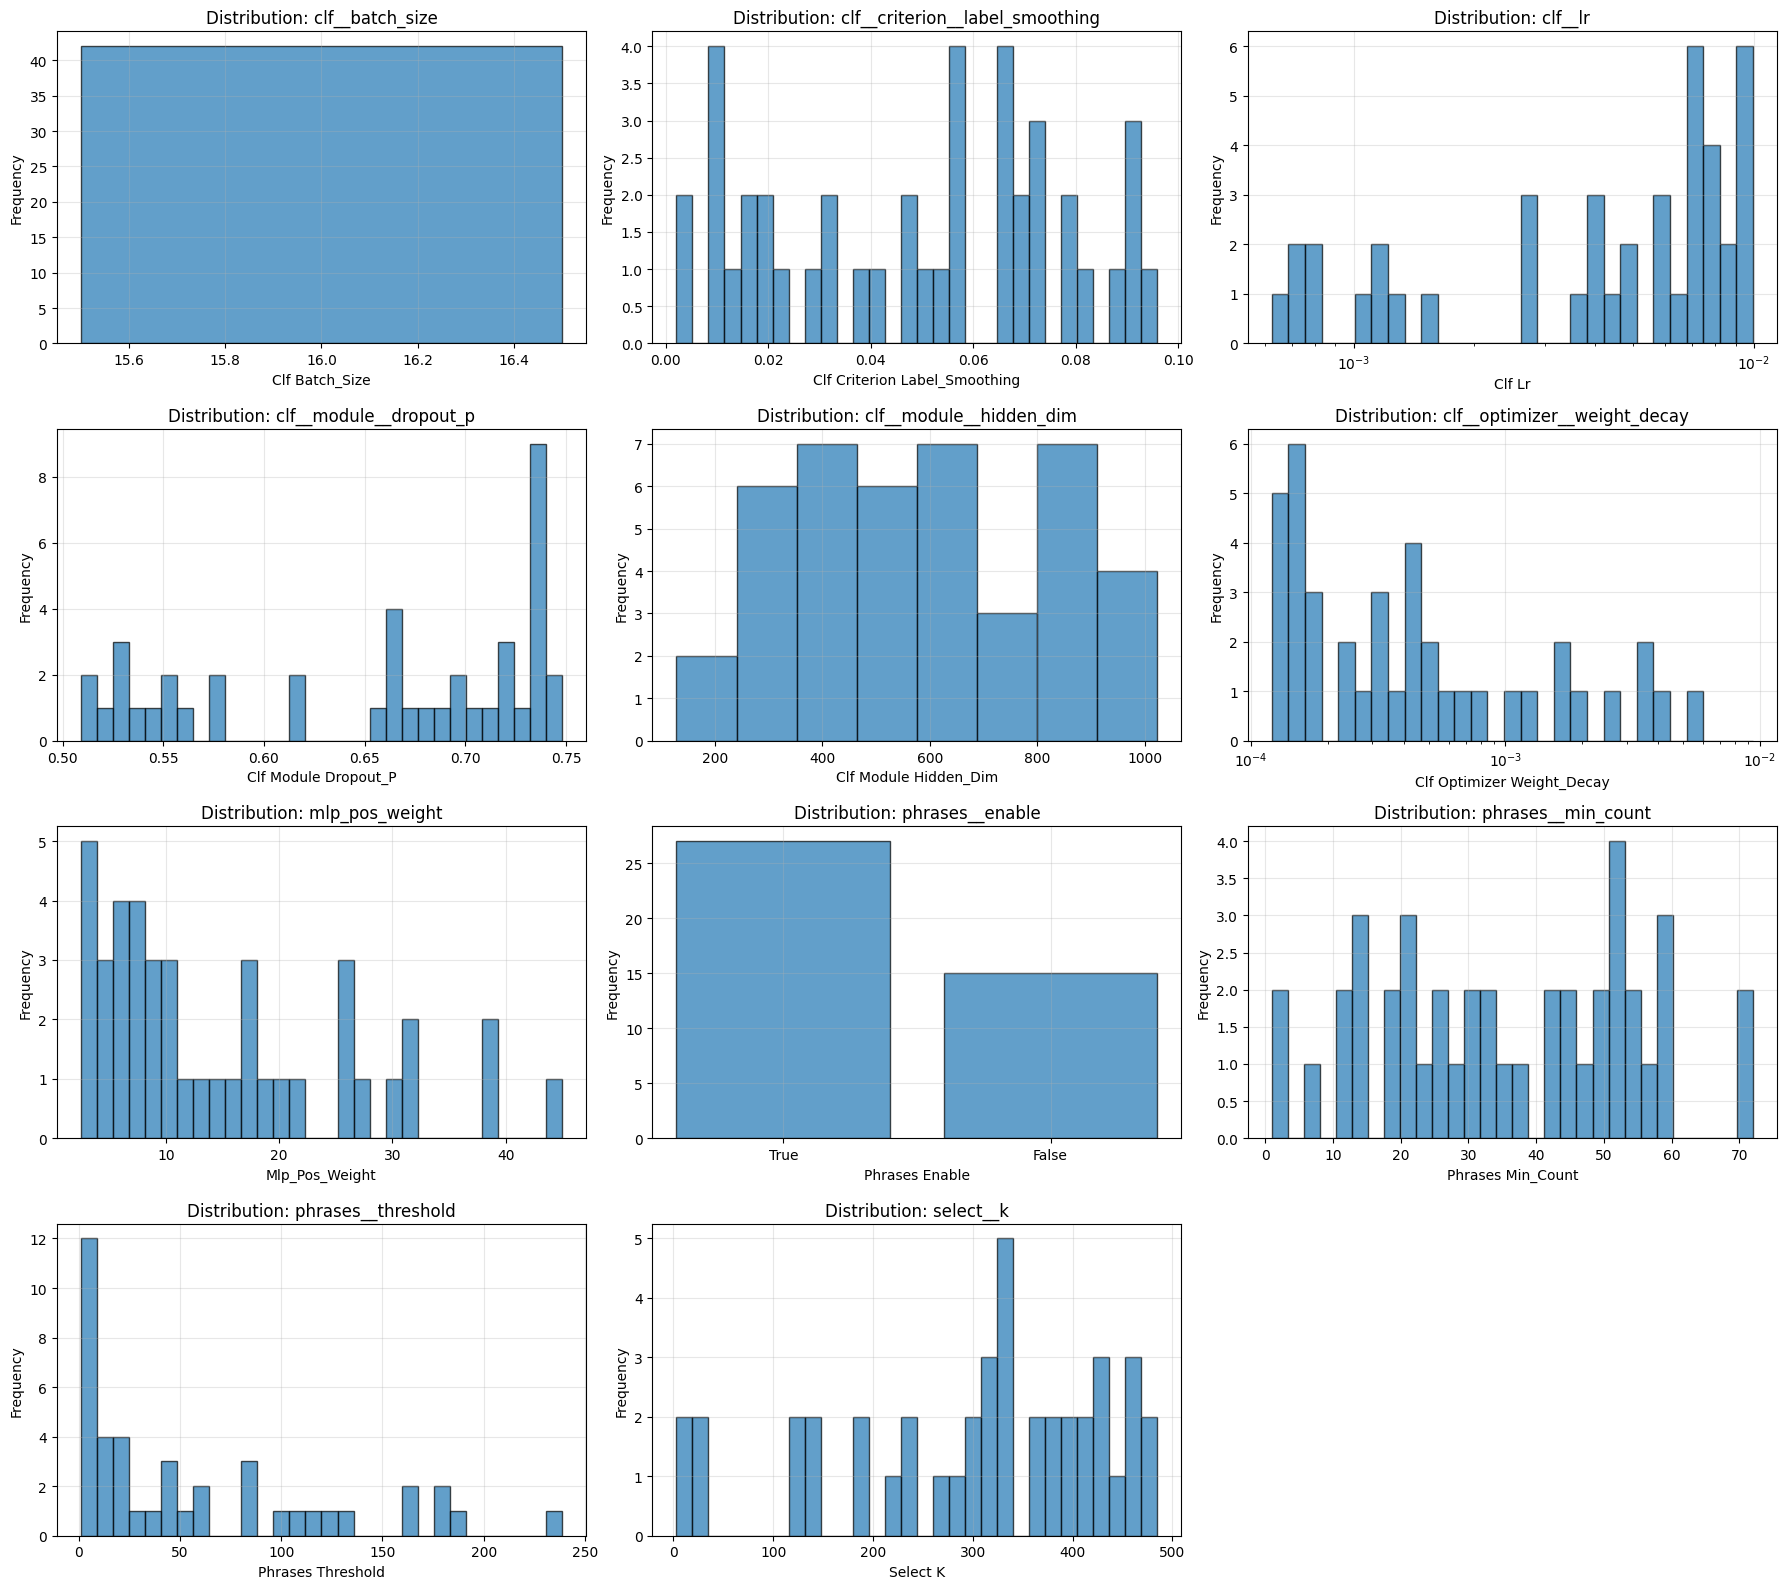


3. Performance vs Individual Parameters:


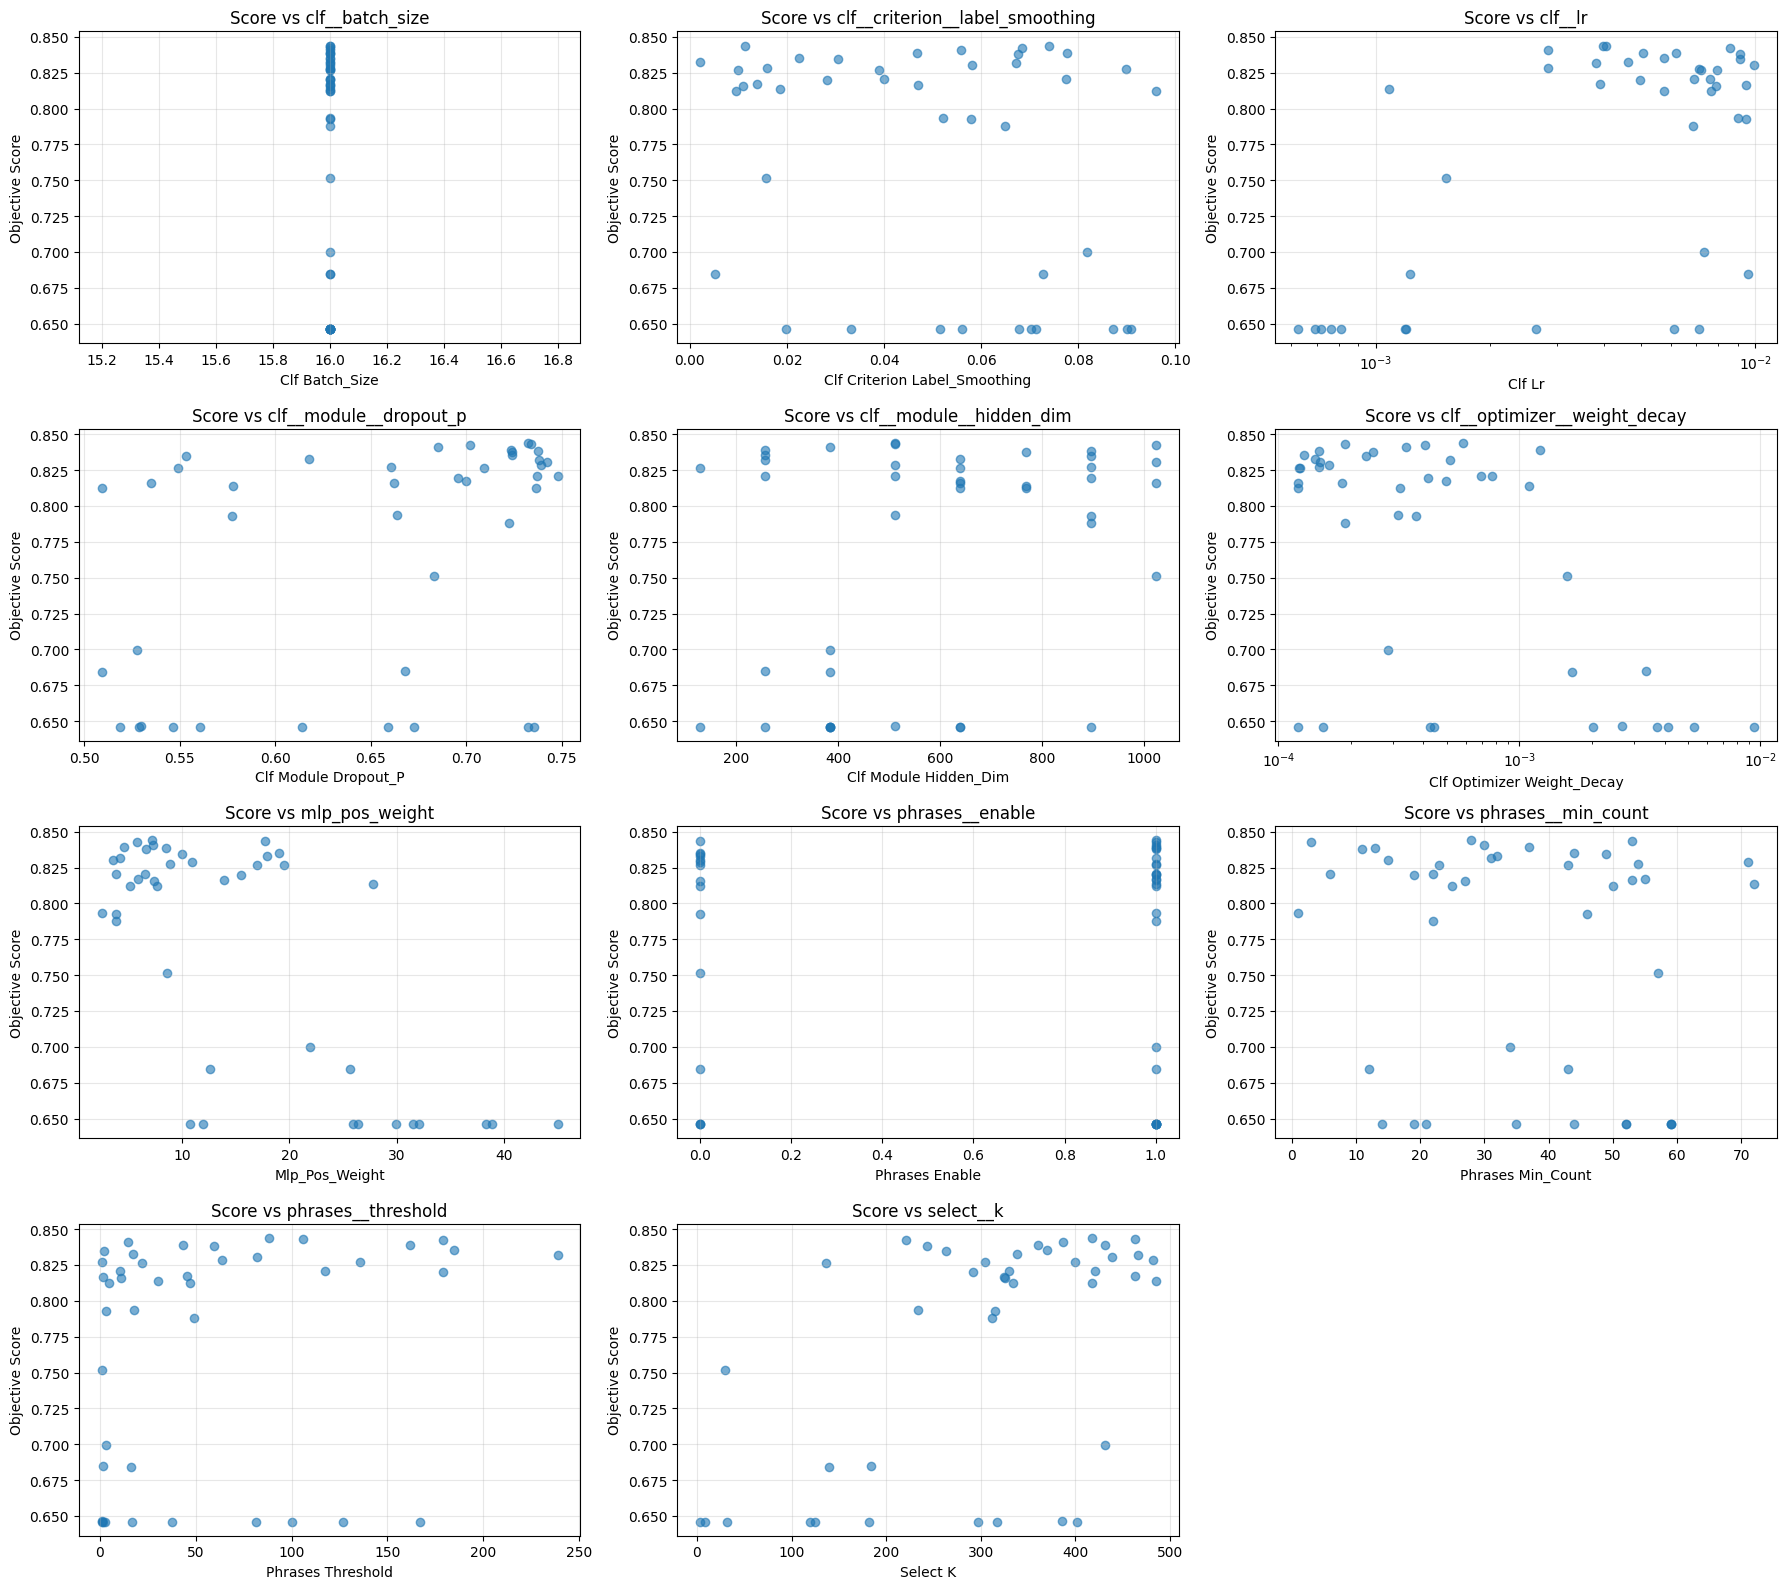


4. Convergence Analysis:


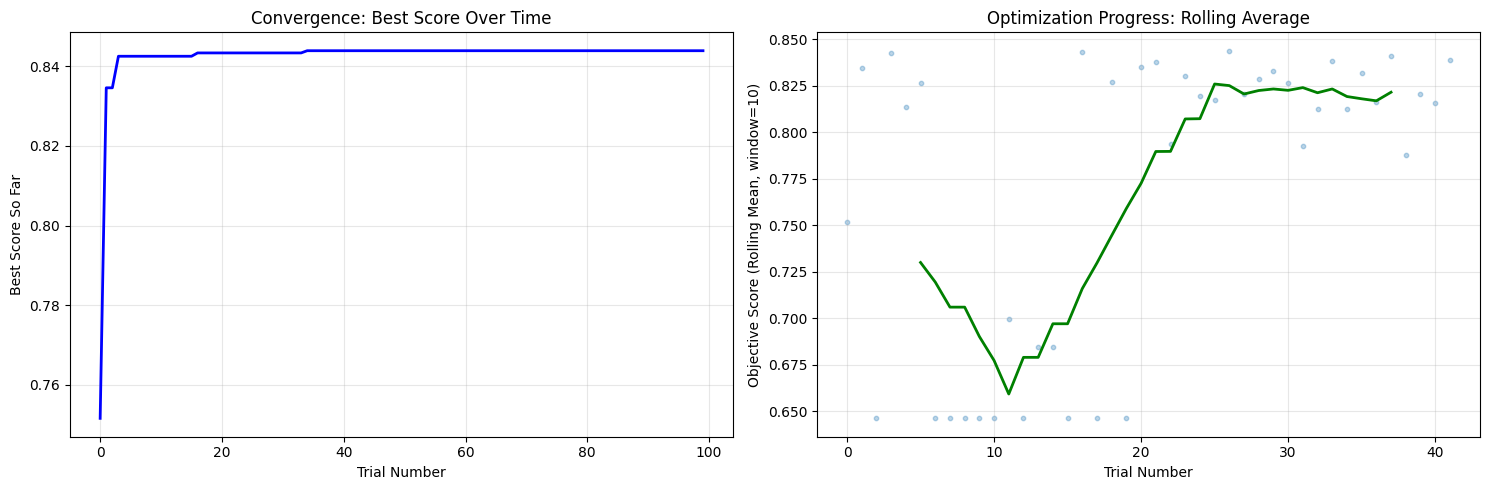


5. Trial Status Overview:


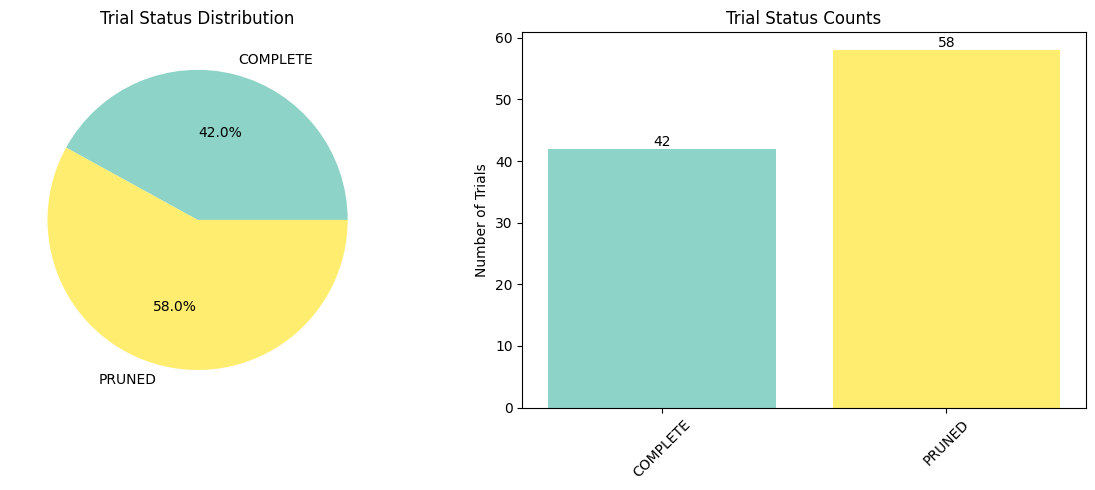


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight enable       min_count    threshold    k           
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    34      0.8439     16           0.0740       0.0041       0.7325       512          0.0006       7.1816       True         28           88.1411      417         
2    16      0.8434     16           0.0113       0.0040       0.7342       512          0.0002       17.7123      False        53           105.7690     463         
3    3       0.8426     16           0.0684       0.0086       0.7021       1024         0.0004       5.7859       True         3            178.8533     221         
4    68      0.8410     16           0.0558       0.0028       0.6855       384          0.0003       7.2709       True         30 

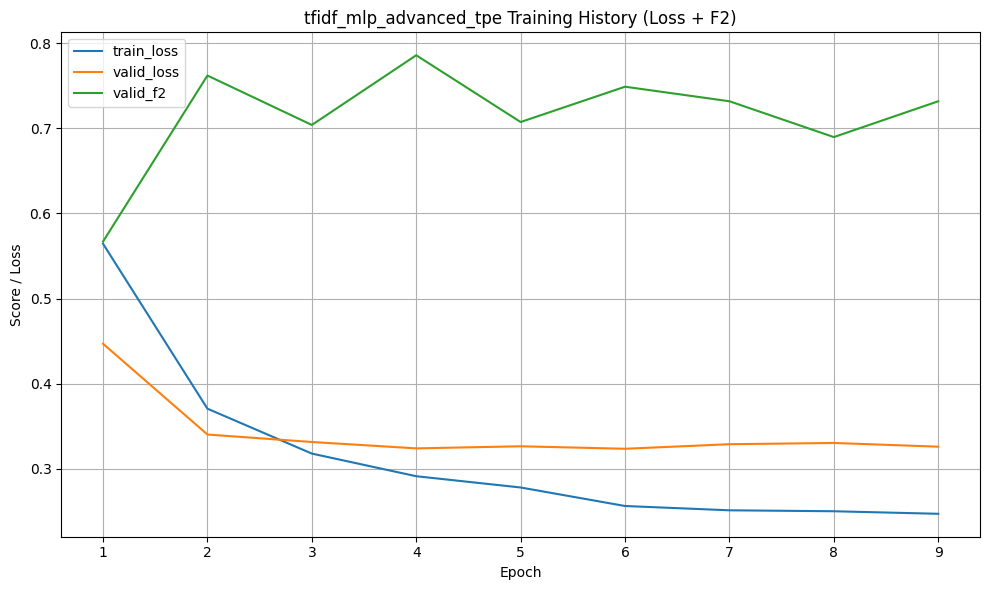


Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.111
CV F2-score with optimized threshold: 0.848

Generating unbiased threshold visualization...


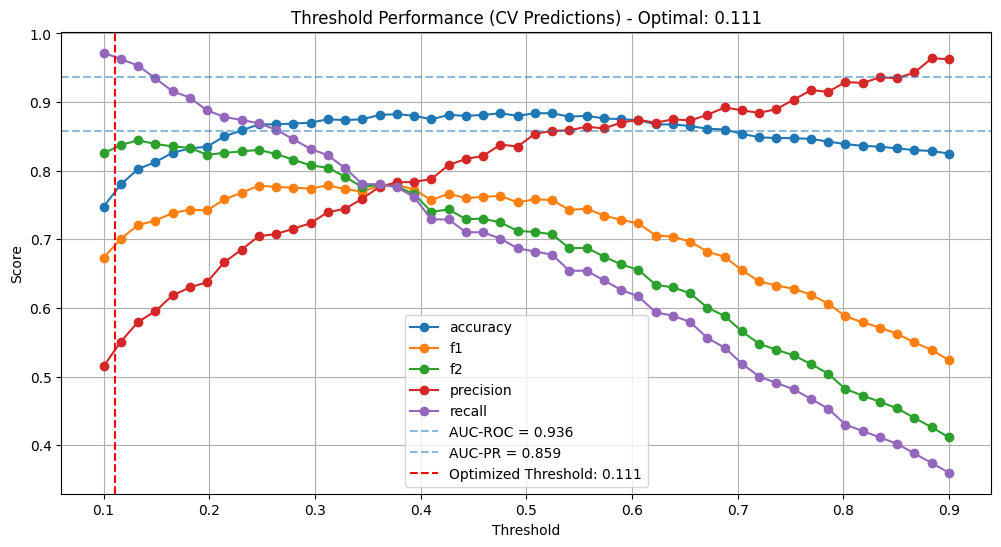

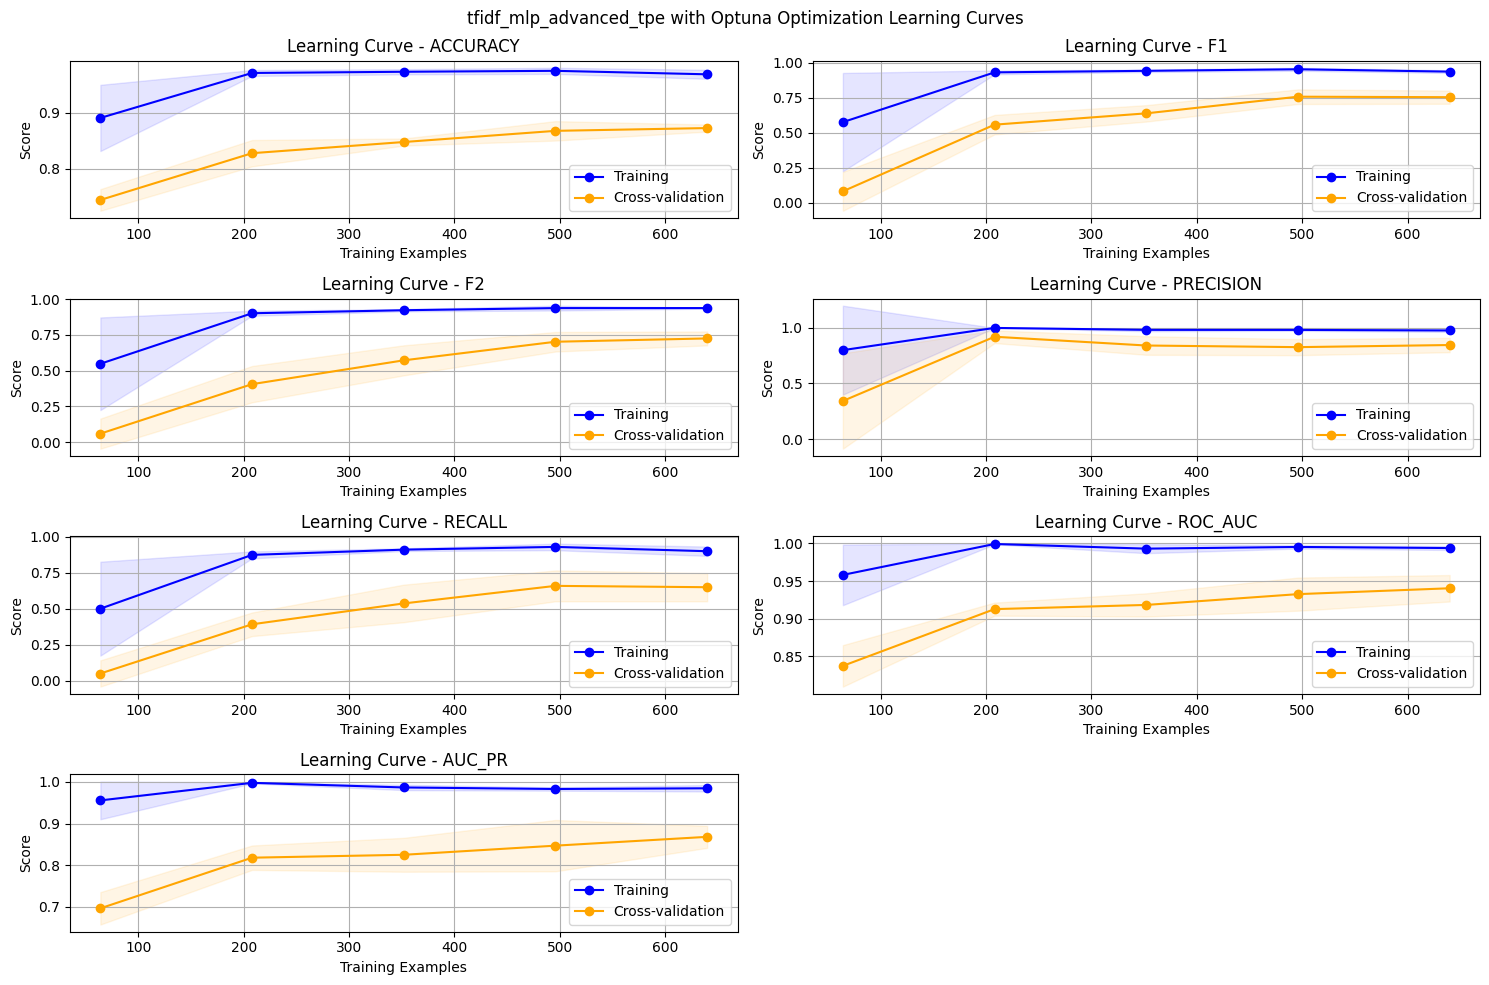


Final Threshold: 0.11
F2-score with default threshold (0.5): 0.613

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       146
           1       0.55      0.93      0.69        54

    accuracy                           0.78       200
   macro avg       0.76      0.82      0.76       200
weighted avg       0.85      0.78      0.79       200

Additional Metrics:
Accuracy   0.775
F2-score   0.814
AUC-ROC    0.920
AUC-PR     0.819



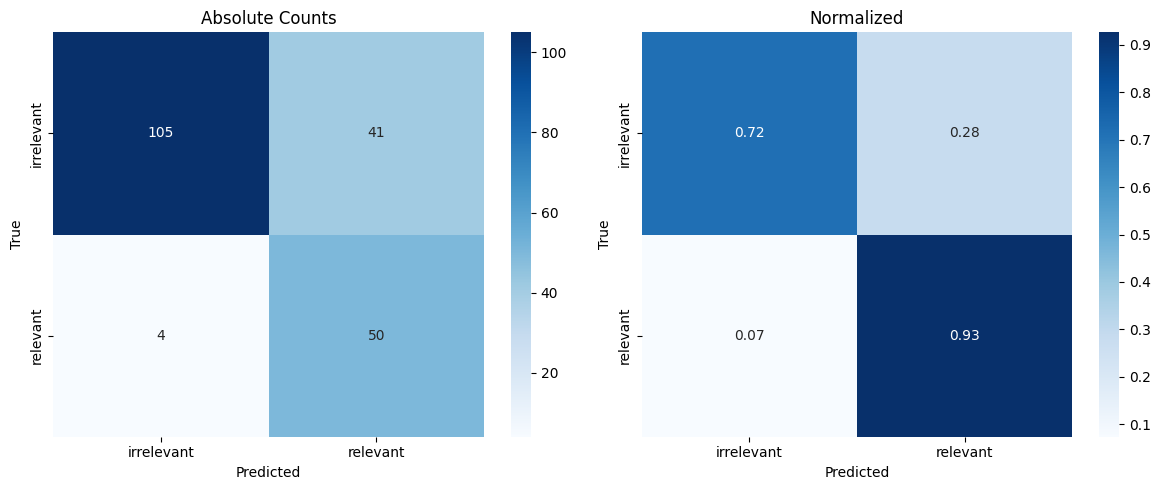

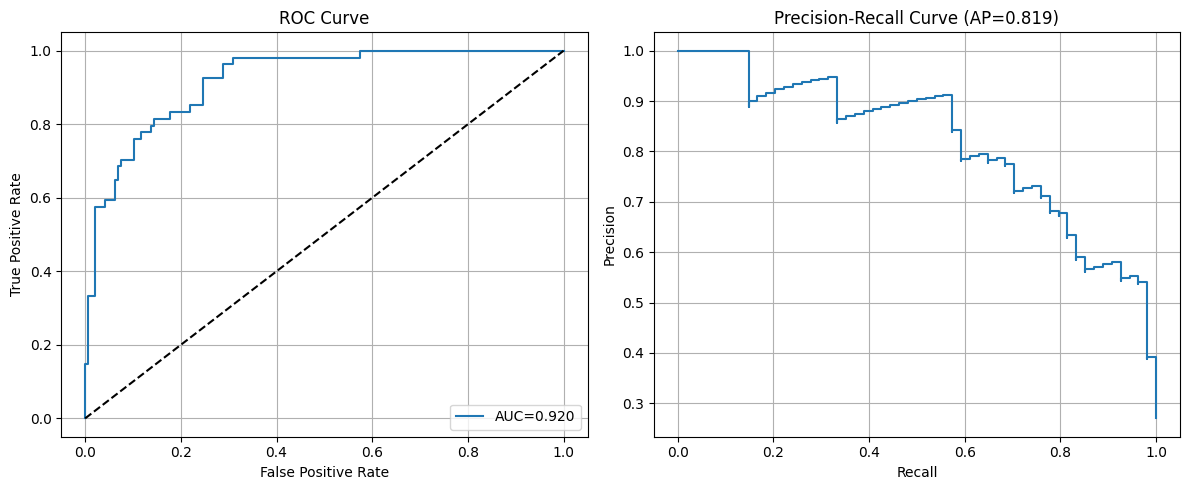


Model saved as model_tfidf_mlp_advanced_tpe.joblib


In [8]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=100, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True,  # use GPU
                use_early_stopping=True, # employ early stopping, see for details in widemlp_skorch.py
                )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 5e-4, 1e-2, log=True),  # Adam LR around 1e-3 
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [16]),  # small batches per paper;
    "clf__module__hidden_dim": lambda t: t.suggest_int("clf__module__hidden_dim", 128, 1024, step=128),  # structured width search around 1024
    "clf__module__dropout_p": lambda t: t.suggest_float("clf__module__dropout_p", 0.5, 0.75),  # focus around 0.5 as optimum per paper
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 1e-4, 1e-2, log=True),  # tiny L2 for stability
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("mlp_pos_weight", 1.0, 50.0)], dtype=torch.float32),  # class weight for positives, force GPU
    "clf__criterion__label_smoothing": lambda t: t.suggest_float("clf__criterion__label_smoothing", 0.0, 0.1), #add some regularization due to overfitting risk
    "select__k": lambda t: t.suggest_int("select__k", 1, 500),  # chi² filter
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),        # 3 Parameters enabled in our advanced (multi word grouping) pipeline.
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "tfidf_mlp_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_mlp,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "mlp",
    n_trials=100,  # Intelligent search with early stopping
    n_startup_trials=20, # less aggressive prunning
    n_warmup_steps=5,  # first 5 epochs not pruned
    intervall_steps=1, # prunning possible for every epoch
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")





MLP GridSearch advanced

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__lr': 0.001, 'clf__module__hidden_dim': 1024, 'clf__module__dropout_p': 0.5, 'clf__optimizer__weight_decay': 0.0014, 'clf__batch_size': 16, 'clf__criterion__label_smoothing': 0.03, 'mlp_pos_weight': 10.0, 'select__k': 200, 'phrases__enable': True, 'phrases__min_count': 14, 'phrases__threshold': 1.5}
Best F2 score during optimization: 0.844

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


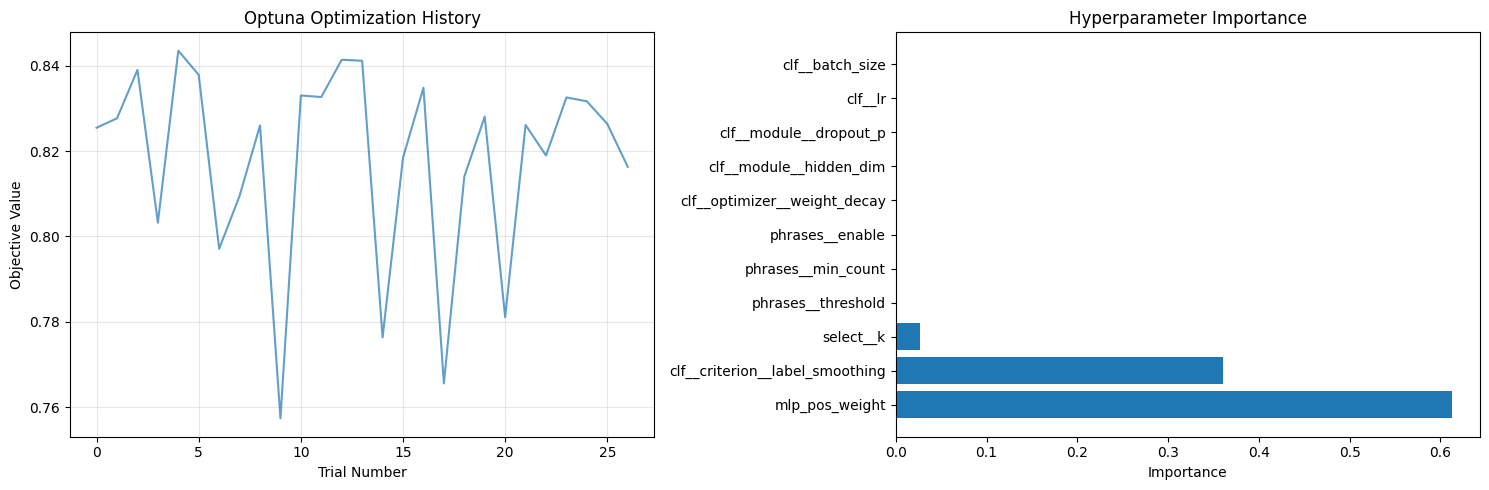


2. Parameter Value Distributions:


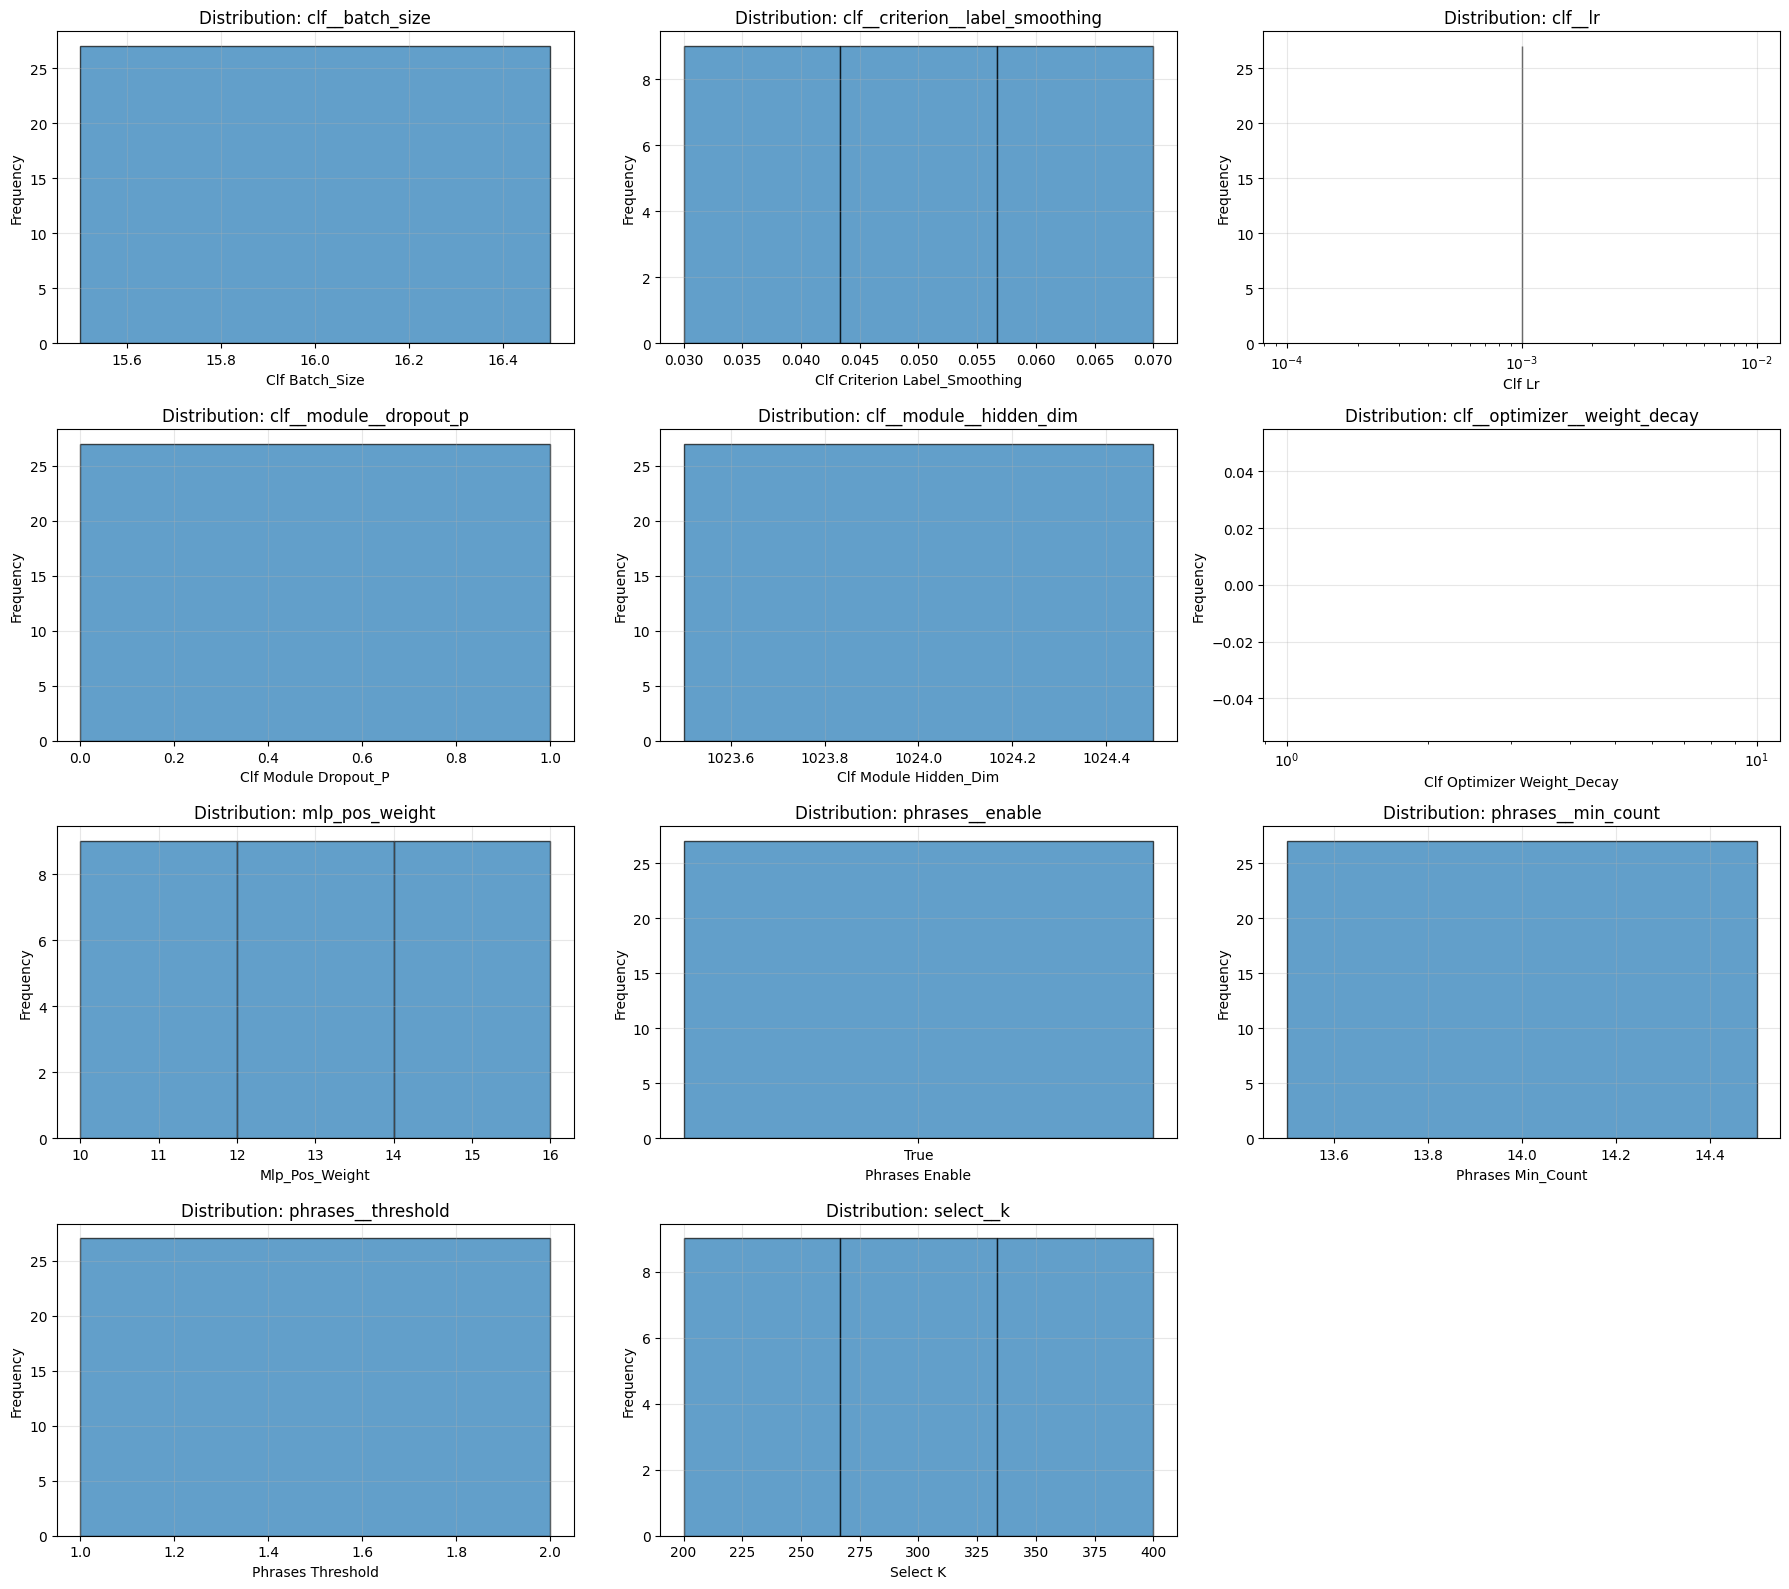


3. Performance vs Individual Parameters:


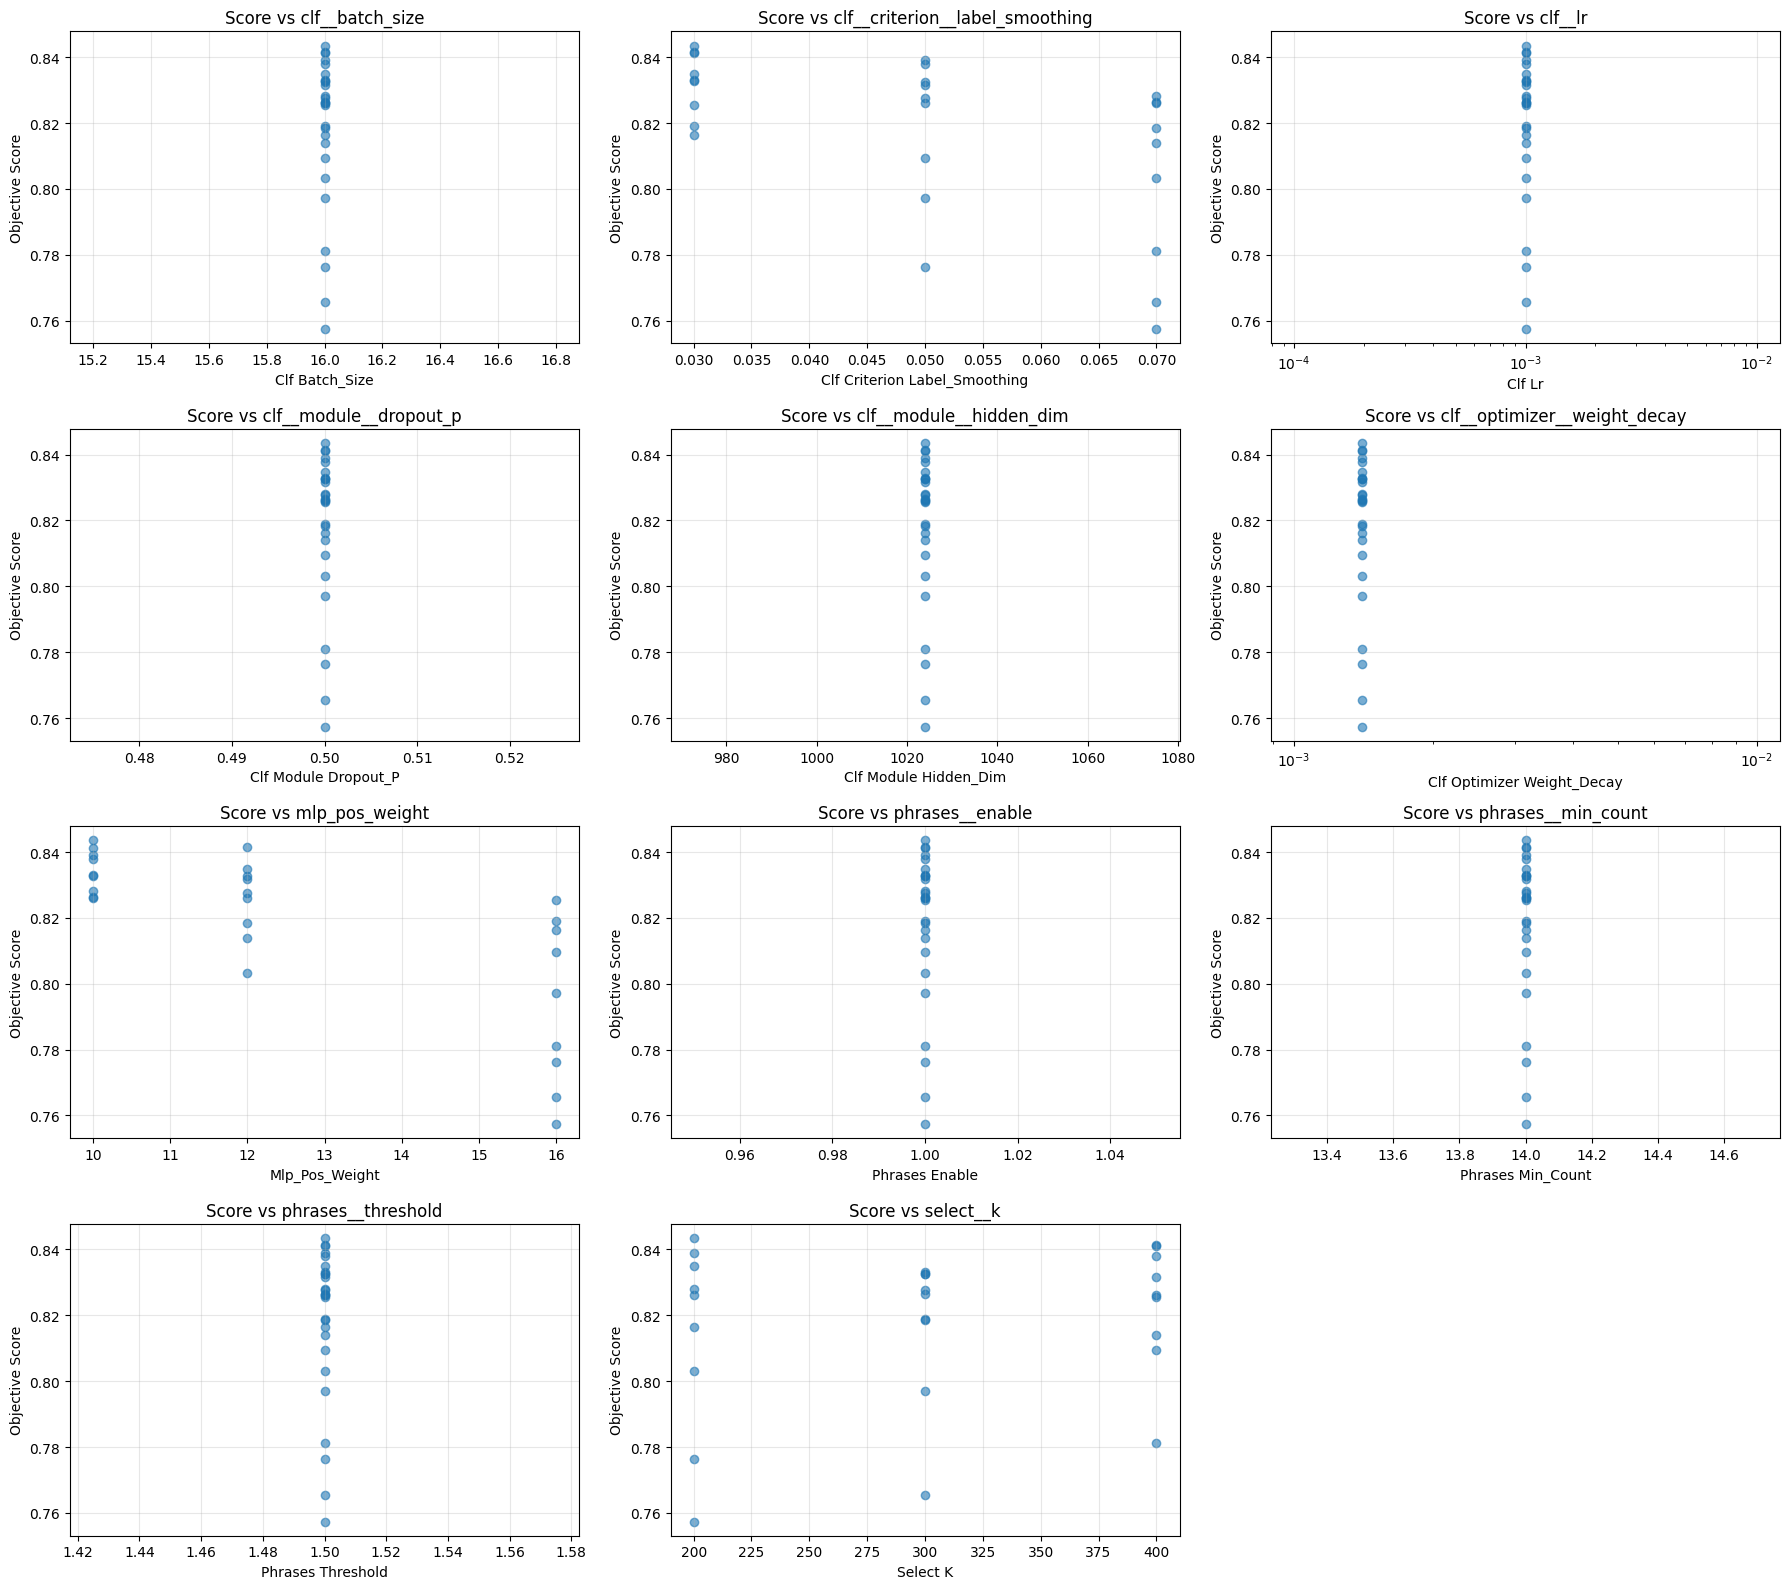


4. Convergence Analysis:


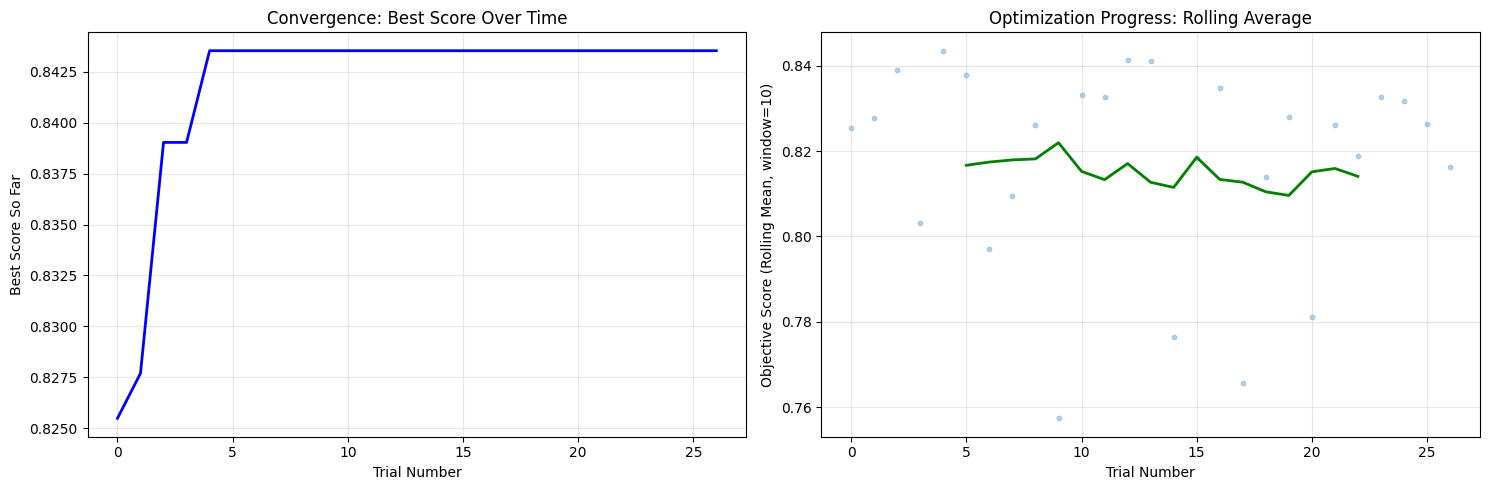


5. Trial Status Overview:


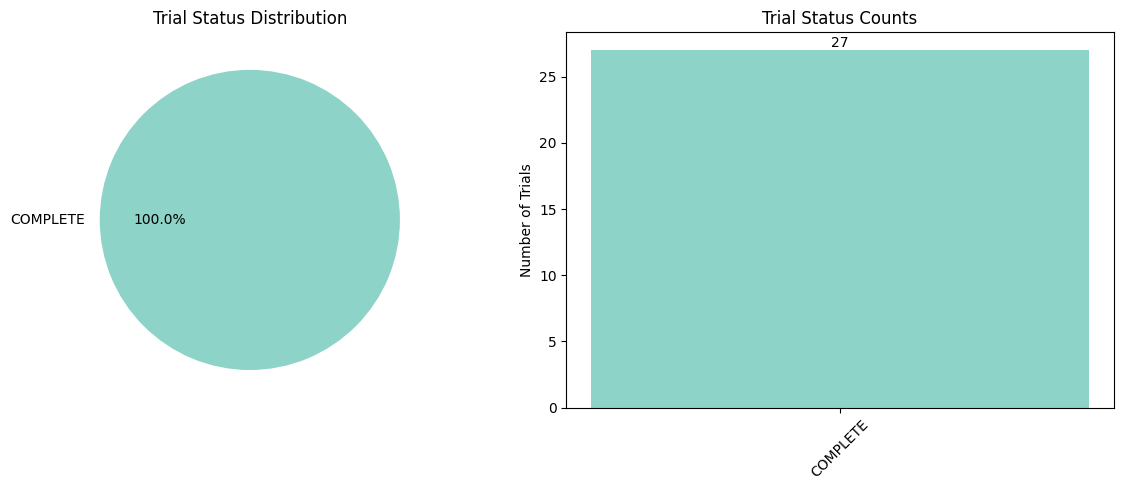


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_p    hidden_dim   weight_decay mlp_pos_weight enable       min_count    threshold    k           
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    4       0.8435     16           0.0300       0.0010       0.5000       1024         0.0014       10.0000      True         14           1.5000       200         
2    12      0.8414     16           0.0300       0.0010       0.5000       1024         0.0014       12.0000      True         14           1.5000       400         
3    13      0.8412     16           0.0300       0.0010       0.5000       1024         0.0014       10.0000      True         14           1.5000       400         
4    2       0.8390     16           0.0500       0.0010       0.5000       1024         0.0014       10.0000      True         14 

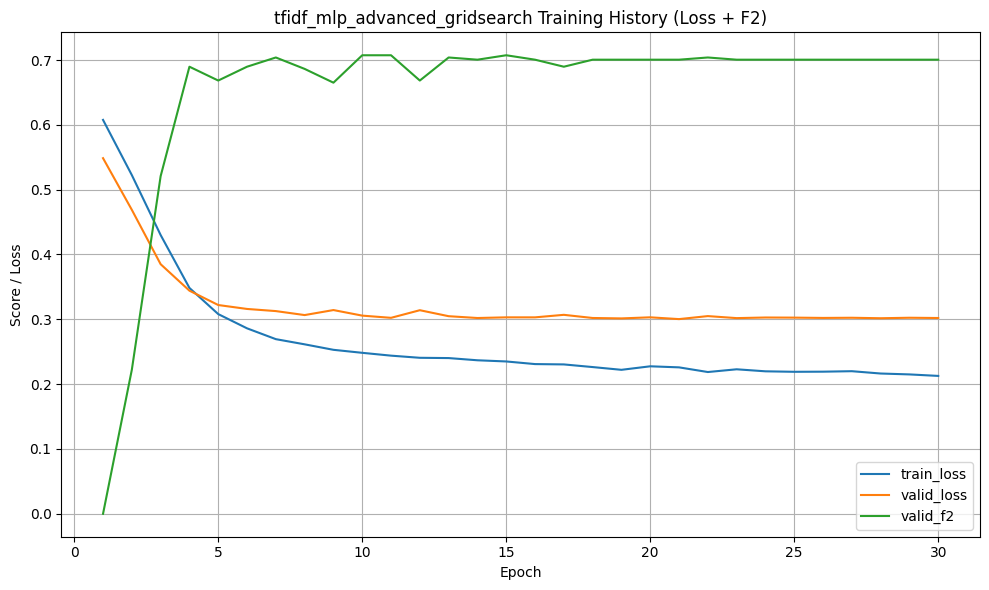


Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.179
CV F2-score with optimized threshold: 0.854

Generating unbiased threshold visualization...


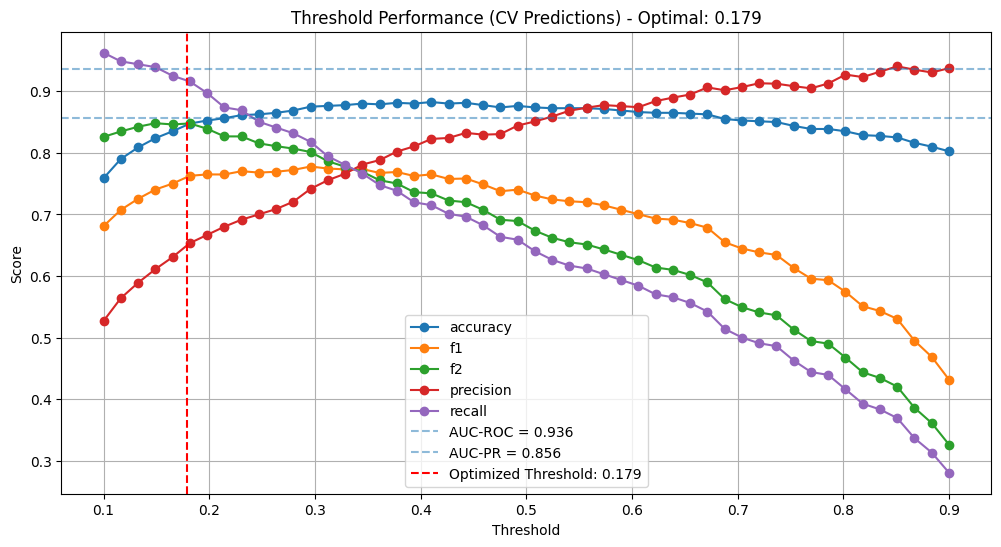

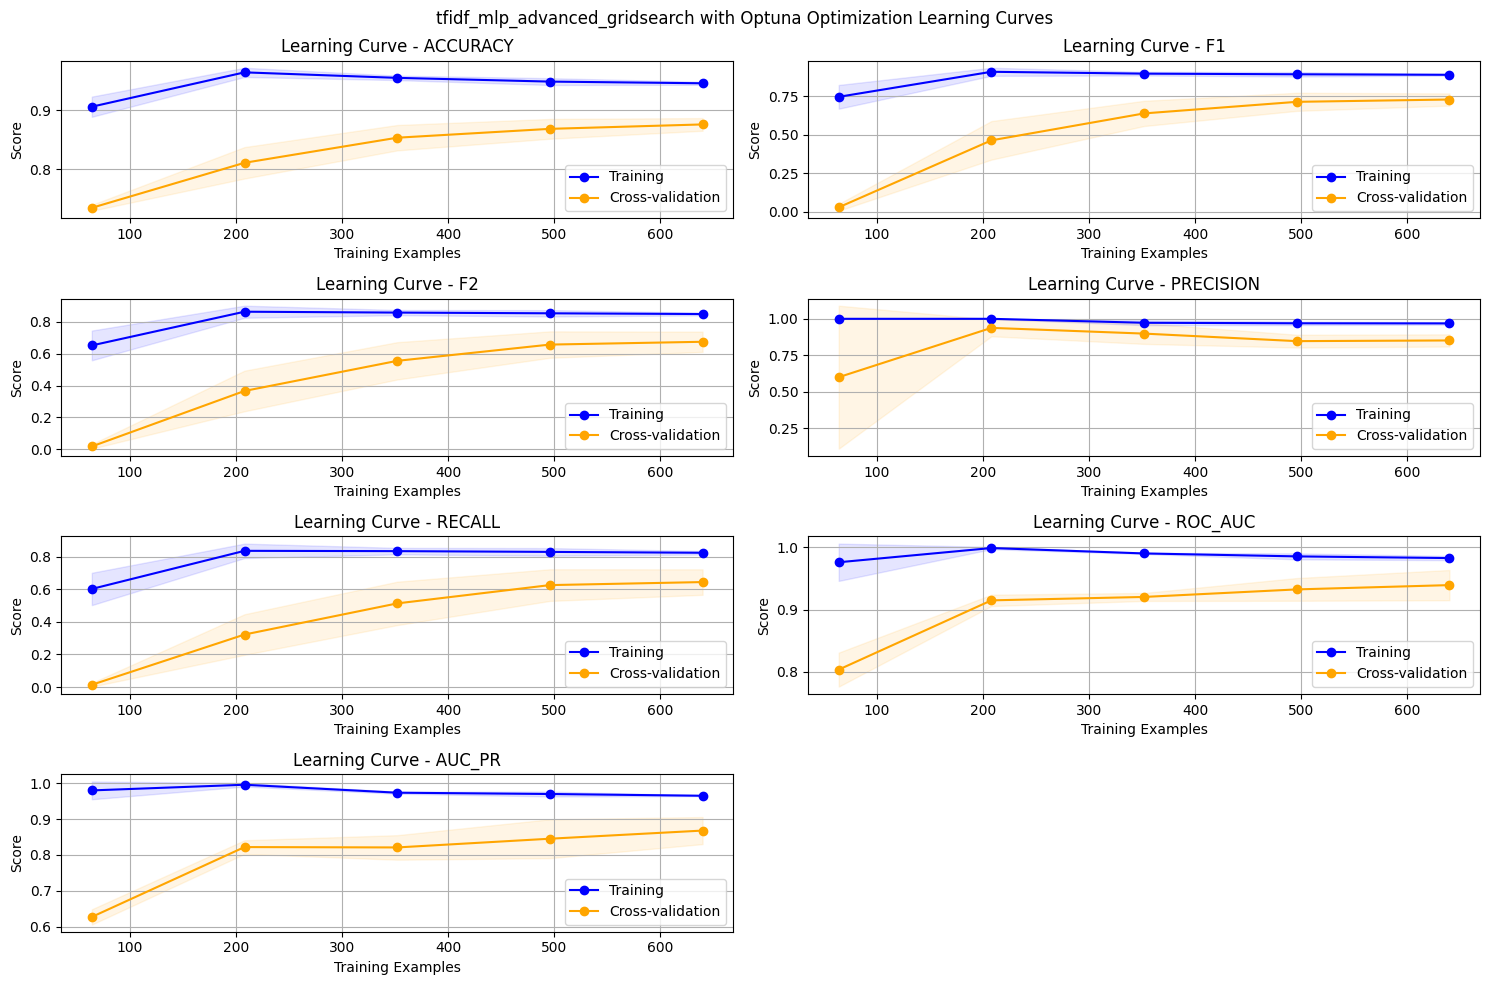


Final Threshold: 0.18
F2-score with default threshold (0.5): 0.647

Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       146
           1       0.60      0.93      0.73        54

    accuracy                           0.81       200
   macro avg       0.78      0.85      0.79       200
weighted avg       0.87      0.81      0.82       200

Additional Metrics:
Accuracy   0.815
F2-score   0.836
AUC-ROC    0.922
AUC-PR     0.802



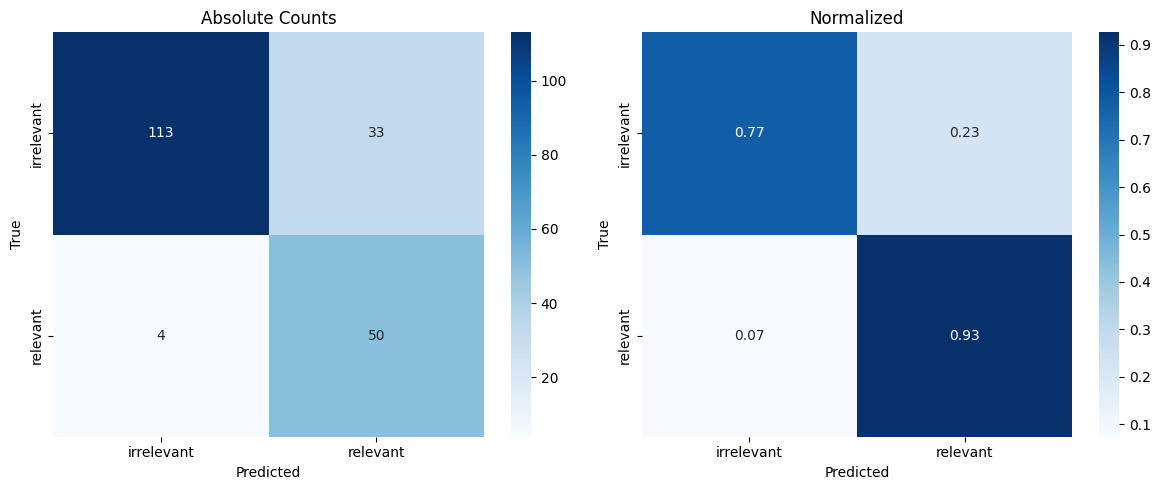

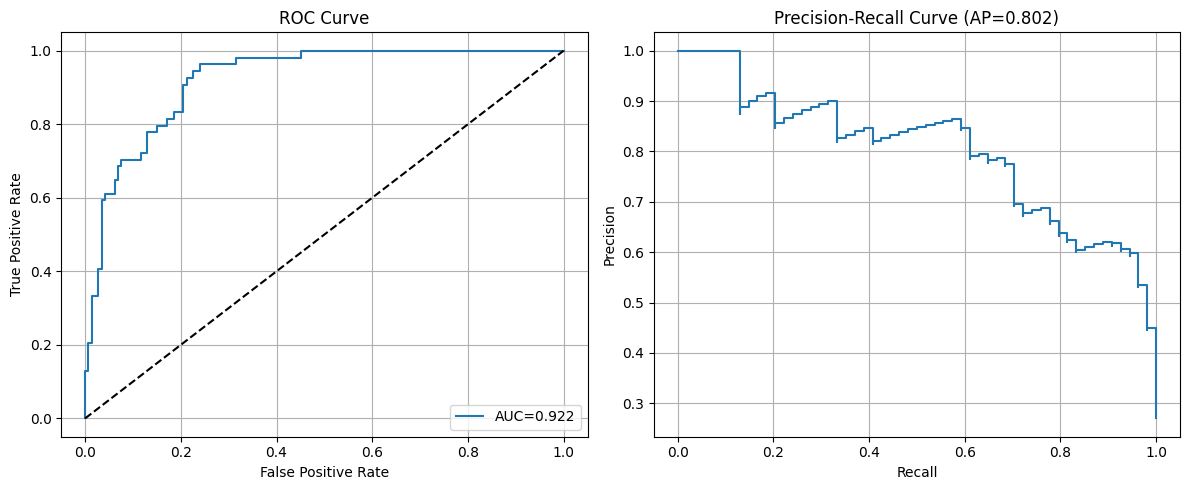


Model saved as model_tfidf_mlp_advanced_gridsearch.joblib


In [12]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

pipeline_tfidf_mlp = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("to32",    ToFloat32Dense()), #important for dense vectors --> MLP demands them
    ("clf",     make_widemlp_skorch( #defaults as in Galke et al. 2022, optimizer, criterion set in widemlp_skorch.py, optimized by optuna tpe
                max_epochs=30, 
                lr=1e-3, 
                batch_size=16, 
                hidden_dim=1024, 
                dropout_p=0.5,
                random_state=42, 
                force_cuda=True,  # use GPU
                use_early_stopping=False #we found best without it
    )),
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearc
#Galke et al. setup with a few variations across chosen parameters based on tpe search

param_grid = {
    "clf__lr": [0.001],                          # fixed Galke et al.
    "clf__module__hidden_dim": [1024],           # fixed Galke et al.
    "clf__module__dropout_p": [0.5],             # fixed Galke et al.
    "clf__optimizer__weight_decay": [0.0014],    # fixed at best (~1.38e-3); slightly stronger L2 helped generalisation
    "clf__batch_size": [16],                     # fixed Galke et al.
    "clf__criterion__label_smoothing": [0.03, 0.05, 0.07],  # small sweep around best (~0.051) to confirm robustness
    "mlp_pos_weight": [10.0, 12.0, 16.0],        # main lever for recall/F2; bracket around best (~10.8) and a tad higher
    "select__k": [200, 300, 400],                # second lever; best near ~297, but several top trials at 348–485 → include higher K
    "phrases__enable": [True],                   # fix to winning setting in best trial to keep grid compact
    "phrases__min_count": [14],                  # fix near best; aggressive phrase discovery matched tpe search
    "phrases__threshold": [1.5],                 # fix near best (~1.45); permissive merging worked well
}


model_name = "tfidf_mlp_advanced_gridsearch"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_mlp,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")